# $\text{Imported Libraries}$

In [ ]:
import os
from os import listdir
from os.path import isfile, join
import re
from matplotlib import cm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.ticker import LinearLocator
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import multiprocessing
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping , CSVLogger
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)


from rich import print


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [ ]:
%%html
<style type='text/css'>
.CodeMirror{
    font-size: 12px;
}

div.output_area pre {
    font-size: 14px;
}
</style>

!jt -t onedork -fs 20 -altp -tfs 20 -ofs 14 -cellw 10%

# $\boxed{\textbf{Emulater for Power Spectrum}}$

## $\textit{Data Reading}$

In [ ]:
my_path = '/home/sanjay/Msc_Project/sanjay_123/Pk_mK2'
path = os.listdir(my_path)


data_pk = []
para_data = []

for file in path:
    f = file.split("_")
    sk1 = np.loadtxt("Pk_mK2/{}".format(file),skiprows = 1)
    para_data.append([float(f[5]),float(f[6]),float(f[7]),float(f[8])])
    data_pk.append(sk1[:,1][2:8])
    
K_vals = sk1[:,0][2:8]
No_sample = sk1[:,3][2:8]
    
data_pk = np.array(data_pk*K_vals**3)
para_data = np.array(para_data)



Data_pk = pd.DataFrame(data = data_pk , 
                        columns = ["K1",
                                   "K2","K3","K4","K5","K6"])

Para_data = pd.DataFrame(data = para_data, 
                        columns = ["X_h",
                                   "M_min","N_ion","R_mfp"])

In [ ]:
xh = Para_data.drop(["M_min","N_ion","R_mfp"],axis = 1)
M = Para_data.drop(["X_h","N_ion","R_mfp"],axis = 1)
N = Para_data.drop(["X_h","M_min","R_mfp"],axis = 1)
R = Para_data.drop(["X_h","M_min","N_ion"],axis = 1)

### $\textit{Plots for Power Spectrum}$ 

In [ ]:
xh = Para_data["X_h"]

num_plots = len(xh)

 


fig, ax = plt.subplots(figsize = (18,9))
colormap = cm.get_cmap('viridis', num_plots)
x = K_vals

for i in range(num_plots):
    y = Data_pk.iloc[i]
    
    ax.loglog(x, y, color=colormap(xh[i]), linewidth=1)
    

sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=xh.min(), vmax=xh.max()))
sm.set_array([])
cbar = plt.colorbar(sm, label='Neutral Fraction $X_h$ $ \longrightarrow$ ',pad = 0.03)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r"k (Mp$c^{-1}$) $ \longrightarrow$",fontsize = 15)
plt.ylabel(r" $\Delta ^{2} (mK^2)$ $ \longrightarrow$" ,fontsize = 15)
plt.title(r"PS for different $X_h$ values",fontsize = 15)

# plt.legend(fontsize = 15)
plt.show()

## $\textit{Statistics}$

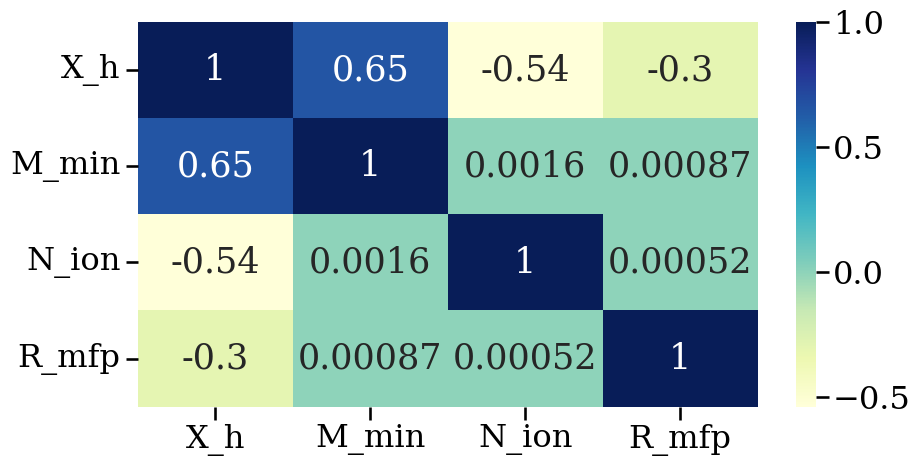

In [19]:
plt.subplots(figsize=(10,5))
dataplot = sb.heatmap(Para_data.corr(), cmap="YlGnBu", annot=True)

## $\textit{Pair Plot}$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

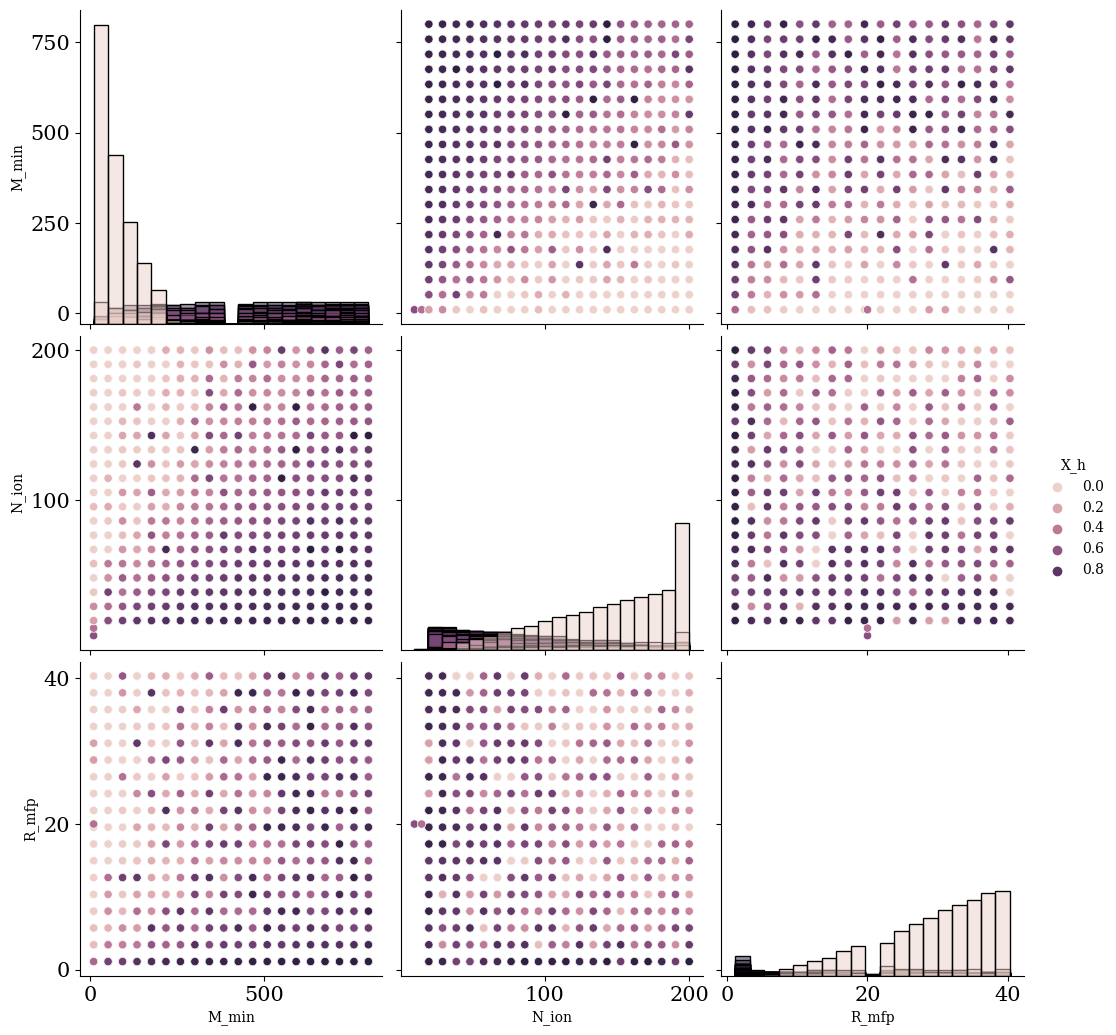

In [9]:
sb.pairplot(Para_data,height = 3.5,hue = 'X_h',diag_kind="hist")
# sb.pairplot(parameters_xh,height = 3.5 ,kind = 'scatter',corner=True,diag_kind = 'kde')
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

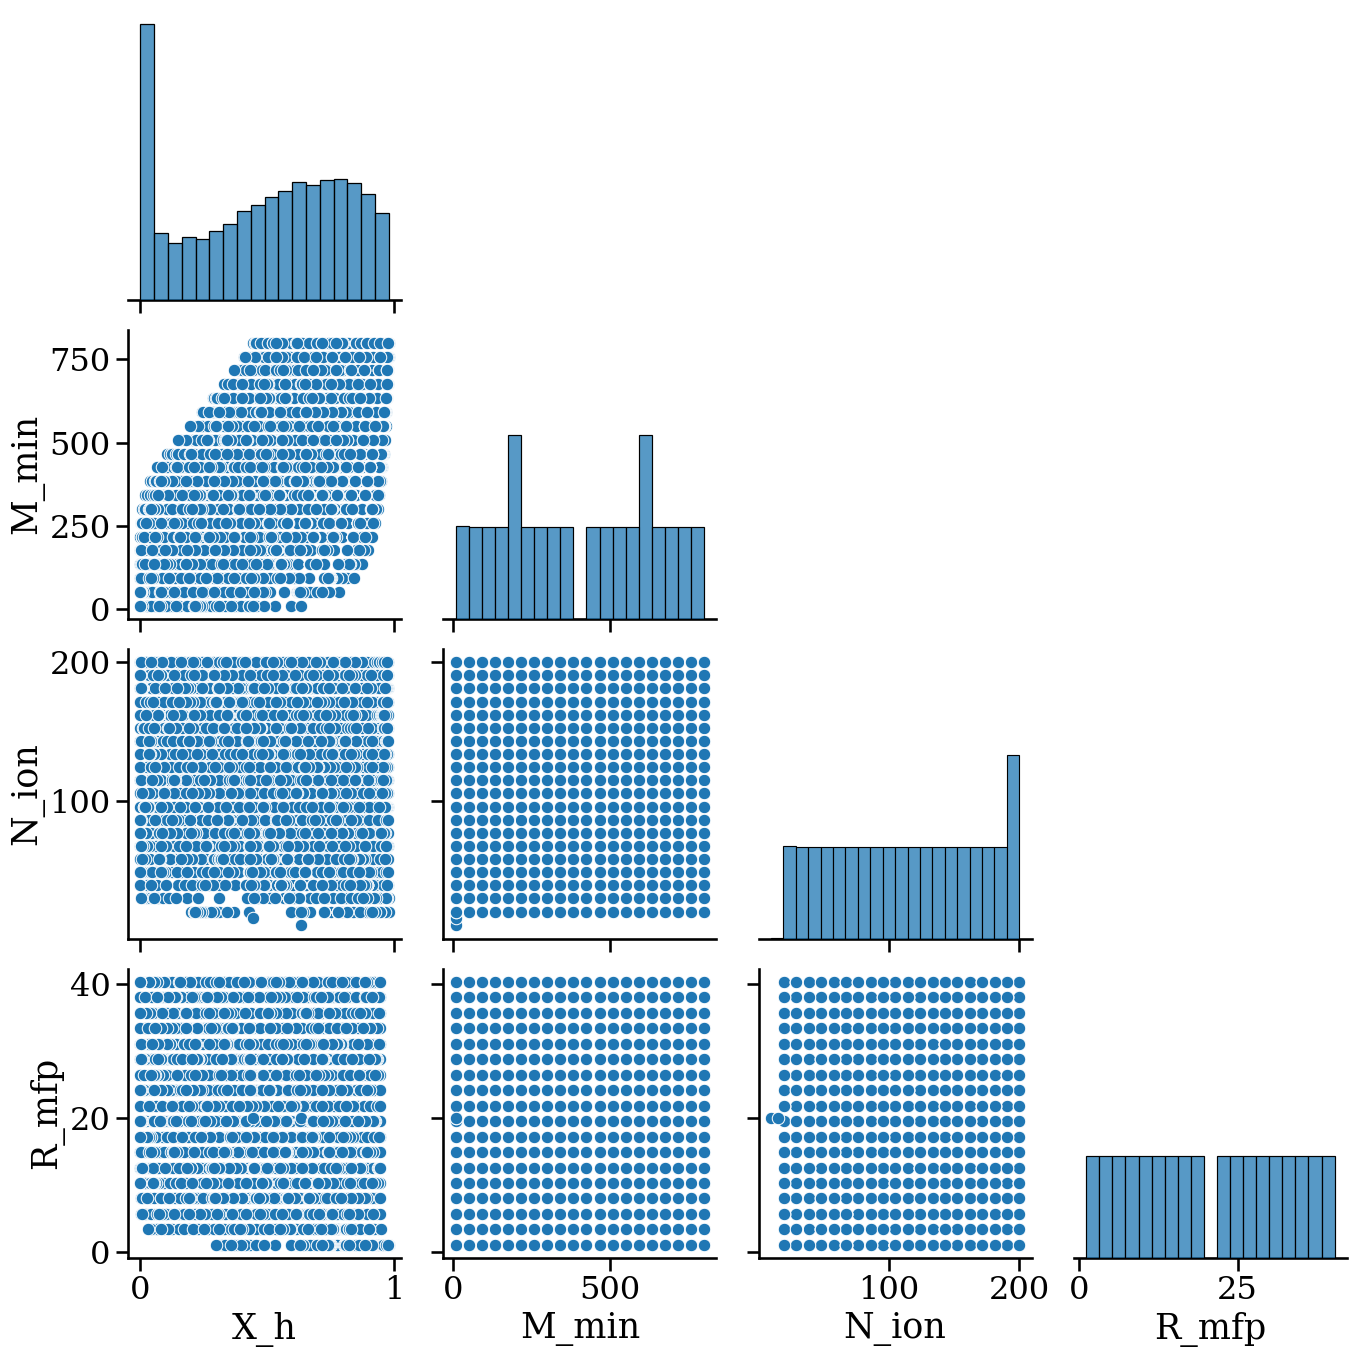

In [10]:
sb.pairplot(Para_data,height = 3.5 ,kind = 'scatter',corner=True,diag_kind = 'hist')
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

# $\textit{Model Architecture}$

#### $\textit{Get Pie-Chart for analysing the features}$

In [ ]:
def get_piechart(xh,a,san):    
    data = np.array(xh).reshape(len(xh),)
    data1 = pd.DataFrame(data)
    ssa = data1.groupby(pd.cut(data, a,right = False,precision = 2,include_lowest = True)).count()

    bs = ssa[0]
    label = bs.index
    bs = np.array(bs)

    labels =label
    sizes = bs
    max_index = np.argmax(sizes)
    min_index = np.argmin(sizes)


    explode = [0.3 if i in [max_index, min_index] else 0 for i in range(len(labels))]


    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.2f%%', shadow=False, startangle=140)
    plt.axis('equal')
    plt.text(-1,1.5,"Pie chart for {} values in {} different ranges".format(san,a),fontsize = 17,color = "blue")
    plt.show()
get_piechart(xh,5,"Neutral Fraction")
# get_piechart(M,5,"M_min")
get_piechart(N,5,"N_ion")
# get_piechart(R,10,"R_mfp")
    

#### $\textit{Pre-Processing}$

In [ ]:
Parameter = Para_data.drop(["X_h"],axis = 1)

from sklearn.preprocessing import StandardScaler
def scaler(Parameter):
    
    scaler = StandardScaler()


    scaler.fit(Parameter)


    scaled_data = scaler.transform(Parameter)


    scaled_df = pd.DataFrame(scaled_data, columns=Parameter.columns)



    return scaled_df

In [ ]:
zero_nf_rows = Para_data[Para_data['X_h']==0]
removel_data = zero_nf_rows.nsmallest(475, 'N_ion')
rm_indx = removel_data.index
md_data = Para_data.drop(rm_indx)
md_pk = Data_pk.loc[md_data.index]


In [ ]:
x_train,x_test,y_train,y_test,xh_train,xh_test = train_test_split(md_data,md_pk
                                                                  ,md_data.drop(["M_min","N_ion","R_mfp"],axis = 1),
                                                                  test_size = 0.2,random_state = 100)

In [ ]:


er_index = []
for i in range(len(xh_train)):
    
    if xh_train["X_h"].iloc[i]<0.15:
        er_index.append(i)
# print(er_index)
print(len(er_index))



w = 8



a = w/len(er_index)
b = (10-w)/(len(xh_train)-len(er_index))

sample_weight = np.zeros(len(xh_train))
for i in range(len(xh_train)):

    for j in er_index:
#     if i == any(er_index):
        if i==j              :
#             print(i)
            sample_weight[i] = a
            break
        else:
            sample_weight[i] = b
            
sample_weight

### $\textit{Architecture}$ 

In [ ]:
def model_creation(x_train, y_train, num_epochs=1000, batch_size=15, validation_split=0.1,sample_weight = None):
    
    EM_model = Sequential()
    EM_model.add(Dense(512, kernel_initializer='uniform', activation='elu', input_dim=x_train.shape[1]))
    EM_model.add(Dense(1024, activation='elu'))
    EM_model.add(Dense(128, activation='elu'))
    EM_model.add(Dense(64, activation='elu'))
    EM_model.add(Dense(y_train.shape[1]))  

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    EM_model.compile(loss='mean_squared_error', optimizer=optimizer,weighted_metrics=['mae'])

    
    callback_p = EarlyStopping(
        monitor="val_loss",
        min_delta=0.1,
        patience=20,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=100
    )

    
    history = EM_model.fit(
        x_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        sample_weight = sample_weight,
        callbacks=[callback_p],
        initial_epoch=0
    )

    return history,EM_model 

import numpy as np

def get_predictions(model, x_test):
    
    if x_test.shape[1] != model.input_shape[1]:
        raise ValueError("Input data shape does not match the model's input shape.")

    # Make prediction
    predictions = model.predict(x_test)

    return predictions






In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

# Define the input layer
input_layer = Input(shape=(3,))

# Define the hidden layers with the specified number of neurons
hl1 = Dense(512, activation='relu',kernel_initializer='uniform')(input_layer)
hl2 = Dense(1024, activation='relu')(hl1)
hl3 = Dense(512, activation='relu')(hl2)
hl4 = Dense(256, activation='relu')(hl3)
hl5 = Dense(128, activation='relu')(hl4)
hl6 = Dense(64, activation='relu')(hl5)

# Define the output layer with 4 neurons (assuming you have 4 output classes)
output_layer = Dense(6)(hl6)

# Create the model
model_with_skip = Model(inputs=input_layer, outputs=output_layer)
optimizer = keras.optimizers.Adam(learning_rate=0.000859)
model_with_skip.compile(loss='mean_squared_error', optimizer=optimizer,weighted_metrics=['mse'])


callback_p = EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=200
)


history = model_with_skip.fit(
    x_train.drop(['X_h'],axis = 1), y_train,
    epochs=1000,
    batch_size=15,
    validation_split=0.1,
    sample_weight = None,
    callbacks=[callback_p],
    initial_epoch=0
)


In [ ]:
y_predict = model_with_skip.predict(x_test.drop(["X_h"],axis = 1))

sanjay_index = np.array(y_test.index.tolist())


 
y_pd_df = pd.DataFrame(data = y_predict, index = sanjay_index,
                        columns = ["K1",
                                   "K2","K3","K4","K5","K6"])


mae_EM = metrics.mean_absolute_error(y_test,y_pd_df)
mse_EM = metrics.mean_squared_error(y_test,y_pd_df)
rsq_EM = metrics.r2_score(y_test,y_pd_df)
# activation_functions = [layer.activation.__name__ for layer in model_pt1[1].layers]
# optimizer_name = model_pt1[1].optimizer.__class__.__name__
print()
print('Mean absolute error is {0:.4f}'.format(mae_EM))
print()
print('Mean squared error is {0:.4f}'.format(mse_EM))
print()
print('R_square score is {}'.format((round(rsq_EM,5))))
print()
# print("Activation Functions :=> ",activation_functions)
print()
# print("Optimizer :=> ",optimizer_name)

# parameters = pd.read_csv('my_log_em.csv')
# parameter_poly_data = pd.DataFrame(parameters)
# pd.set_option("display.max_columns",None)
# # pd.set_option("display.max_rows",163)

# parameter_poly_data.tail()



## $\boxed{\textbf{Testing of Emulater}}$

#### $\textit{plots}$

In [ ]:
NF = xh_test["X_h"]

In [ ]:
k = 0
for i in range(0,len(xh_test)):
    if NF.iloc[i]>=0.1:
        k +=1
        a, b = y_test.iloc[i] , y_pd_df.iloc[i] 
        # y_max = (max(max(a),max(b))) + 
        error_ = abs(a-b)
        rel_error = (error_/a)*100


#         y_max1 = 1 + max(rel_error)
#         y_min = min(rel_error) - 0.5
 
        plt.figure(figsize=(20, 7))
        G = gridspec.GridSpec(1, 3,wspace=0.3,hspace=0.5)
        ax1 = plt.subplot(G[0, :2])
    #         ax2 = plt.subplot(G[0,1])
    #         ax2.set_xticks(())
        ax3 = plt.subplot(G[0, 2])

        plt.suptitle(r"Figure %d :- Power Spectrum at $x_h$ = %.3f" %(k,NF.iloc[i]),
                     fontsize = 22,color = "firebrick",y = 1.1)


        ax1.loglog(K_vals,b,'go--',label = "Predicted PS")
        ax1.loglog(K_vals,a,'ko--',label = "Actual PS")
        ax1.set_title("Power Spectrum",color = 'blue',fontsize = 17)
        ax1.set_xlabel(r"k (Mp$c^{-1}$) $ \longrightarrow$",fontsize = 17,color = 'darkgreen')
        ax1.set_ylabel(r" $\Delta ^{2} (mK^2)$ $ \longrightarrow$" ,fontsize = 17,color = 'darkgreen')
        ax1.legend(fontsize = 15)
        
        p,q,r = md_data.drop(["X_h"],axis = 1).iloc[i]
        ax1.set_title(r'Parameters:  $M_{min}$ = %.3f , $N_{ion}$ = %.3f , $R_{mfp}$ = %.3f'%(p,q,r),
                 fontsize=17,color='purple',bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 10},loc='right',x= 1.3,y = 1.133)
        ax3.set_box_aspect(11/12)
        ax3.semilogx(K_vals,rel_error,'go--',label = " Relative error in %")

    #         ax3.yaxis.set_major_locator(MultipleLocator(0.5))
        ax1.yaxis.set_major_formatter('{x:.0f}')
        ax3.yaxis.set_minor_locator(MultipleLocator(0.5))


#         ax3.set_ylim(y_max1)
        ax3.set_ylabel(r"Error $ \longrightarrow$" ,fontsize = 15,color = 'darkgreen')
        ax3.set_title("Relative Error in Prediction",color = 'blue',fontsize = 17)
        ax3.set_xlabel(r"k (Mp$c^{-1}$) $ \longrightarrow$",fontsize = 17,color = 'darkgreen')
        ax3.legend(fontsize = 12)
        plt.show()

##  $\textit{Interective Results}$

#### $\textit{Function for plots}$

In [54]:
def get_plot(index,xh_val,no_plot):
    
    k = 0
    for i in index:
             
        k = k + 1
        a, b = y_test.loc[i] , y_pd_df.loc[i]

        error_ = abs(a-b)
        rel_error = (error_/a)*100


        y_max1 = 1 + max(rel_error)
        y_min = min(rel_error) - 0.1

        plt.figure(figsize=(20, 7))
        G = gridspec.GridSpec(1, 3,wspace=0.3,hspace=0.5)
        ax1 = plt.subplot(G[0, :2])
   
        ax3 = plt.subplot(G[0, 2])

        plt.suptitle(r"Figure %d :- Power Spectrum at $x_h$ = %.3f" %(k,xh_val),
                     fontsize = 22,color = "firebrick",y = 1.1)

        ax1.loglog(K_vals,b,'go--',label = "Predicted PS")
        ax1.loglog(K_vals,a,'ko',label = "Actual PS")
        ax1.set_title("Power Spectrum",color = 'blue',fontsize = 17)
        ax1.set_xlabel(r"k (Mp$c^{-1}$) $ \longrightarrow$",fontsize = 17,color = 'darkgreen')
        ax1.set_ylabel(r" $\Delta ^{2} (mK^2)$ $ \longrightarrow$" ,fontsize = 17,color = 'darkgreen')
        ax1.legend(fontsize = 15)
        p,q,r = md_data.drop(["X_h"],axis = 1).iloc[i]
        ax1.set_title(r'Parameters:  $M_{min}$ = %.3f , $N_{ion}$ = %.3f , $R_{mfp}$ = %.3f'%(p,q,r),
                 fontsize=17,color='purple',bbox={'facecolor': 'white', 'alpha': 0.6, 'pad': 10},loc='right',x= 1.07,y = 1.134)

        ax3.set_box_aspect(11/12)
        ax3.semilogx(K_vals,rel_error,'go--',label = " Relative error in %")

    #         ax3.yaxis.set_major_locator(MultipleLocator(0.5))
        ax1.yaxis.set_major_formatter('{x:.0f}')
#         ax3.yaxis.set_minor_locator(MultipleLocator(0.5))


#         ax3.set_ylim(y_min,y_max1)
        ax3.set_ylabel(r"Error $ \longrightarrow$" ,fontsize = 15,color = 'darkgreen')
        ax3.set_title("Relative Error in Prediction",color = 'blue',fontsize = 17)
        ax3.set_xlabel(r"k (Mp$c^{-1}$) $ \longrightarrow$",fontsize = 17,color = 'darkgreen')
        ax3.legend(fontsize = 12)
        plt.show()
        if k == no_plot:
            break

#### $\textit{Function for Interaction to the computer}$

In [45]:
def interaction():
        
    s = 0
    while s<1:
        print("")
        print("[bold bright_red] Instructions:-")
        print("")
        print("[bright_blue] Please provide me the value of neutral fraction at which you want to see the Power Spectrum.")
        print("[bright_blue italic underline] Note: The value of neutral fraction should be between 0 to 1.")
        print("")
        xh_val = input("Enter a number (or 'q' to quit): ")
        if xh_val.lower() == 'q':
            print("[bold bright_magenta] Bye! We are leaving the loop.")
            break
        else:
            xh_val = float(xh_val)
            if 0<=xh_val<1:

                xx = xh_test.loc[xh_test["X_h"]==xh_val]

                if len(xx) ==0:

                    print(" ")
                    print("[green] ===>  Sorry! I didn't found any Power Spectrum plot at neutral fraction %.3f in testing data set."%(xh_val))
                    print(" ")
                    print("[green] ===>  Provide a range so that I can give you neighbour neutral fraction values around this %.3f value."%xh_val)
                    print("")
                    print("[green] ===>  If you want very close value then please provide very short range like 0.01,0.011 etc.")
                    rang = input("Enter the range (or 'q' to quit): ")
                    if rang.lower() == 'q':
                                 print("[bold bright_magenta] Bye! We are leaving the loop.")
                                 break
                    else:
                        ss = 0
                        while ss<1:
                            
                            rang = float(rang)
                            xh1 =  xh_val - rang
                            xh2 = xh_val + rang
                            new_index = xh_test.query(" %.3f <= X_h <= %.3f"%(xh1,xh2)).index.tolist()
                            NF_array = xh_test.loc[new_index]
                            NF_array = NF_array['X_h'].to_numpy()
                            if len(NF_array)==0:
                                print("[bright_blue] Sorry! there is no any neighbour in this range. Please increase your range.")
                                rang = float(input("Enter new range:  "))

                            else:
                                print()
                                print("[green] ===>  oh! I found {} neutral fraction values which are neighbours of previous value".format(len(new_index)))
                                print(" ")
                                print("[green] ===>  List of these values is here:")
                                print()
                                print(np.sort(NF_array))
                                print()
                                print("[green] ===>  Please select one of the neutral fraction value from above list at which you want to see the power spectrum.")
                                print(" ")
                                print(" ")
                                ss = ss+1

                else:
                    if len(xx)==1:
                        s = s+1
                        print("[green] ===>  I found {a} Power Spectrum plots which is here:-".format(a = len(xx)))
                        index = xx.index
                        get_plot(index,xh_val,len(xx))
                    else:
                        s = s+1
                        print("[green] ===>  I found {a} Power Spectrum plots. How many do you want to see?. Please provide me a number.".format(a = len(xx)))
                        no_plot = input("Enter a number (or 'q' to quit): ")
                        if no_plot.lower()=='q':
                            print("[bold bright_magenta] Bye! We are leaving the loop.")
                            break
                        else:
                            no_plot = float(no_plot)

                            if no_plot<1:


                                print("[green] ===>  oh! I think you made a mistake[/green], [bold cyan] Please provide me a valid number[/bold cyan].")
                                print("[green] ===>  If this is not your mistake then please enter 1 or enter 0 if you want to change number of plot.")
                                choice = float(input("Enter your choice:  "))
                                san = 0
                                while san<1:

                                    if choice==1:
                                        print("[bold cyan italic] ===>  Better luck next time")
                                        san = san +1
                                    elif choice==0:
                                        no_plot = input("Enter a number howmany plots do you want (or 'q' to quit): ")
                                        if no_plot.lower() == 'q':
                                            print("[bold bright_magenta] Bye! We are leaving the loop.")
                                            break
                                        else:
                                            no_plot = float(no_plot)

    #                                         print("[bold cyan italic] ===>  I got your input that you want to see {} plots. If you want to continue with {} plots then type 0 or if you want to change number of plots then type 1".format(no_plot,no_plot))
    #                                         feed = int(input("Enter your choice:  "))
    #                                         if feed ==1:
    #                                             print("[bold cyan italic] ===>  Please re-enter howmany plots do you want.")
    #                                             no_plot = int(input("Enter a number:  "))
    #                                             index = xx.index
    #                                             get_plot(index,xh_val,no_plot)

    #                                         else:
                                            index = xx.index
                                            get_plot(index,xh_val,no_plot)
                                            san = san+1
                                    else:
                                        print("[bold bright_magenta] You are giving invalid input. Try again!")
                                        choice = float(input(" Enter your choice again  "))

                            else:

#                                 print("[bold cyan italic] ===>  I got your input that you want to see {} plots. If you want to continue with {} plots then type 0 or if you want to change number of plots then type 1".format(no_plot,no_plot))
#                                 feed = int(input("Enter your choice: "))
#                                 if feed ==1:
#                                     print("[bold cyan italic] ===>  Please re-enter howmany plots do you want.")
#                                     no_plot = int(input("Enter a number: "))
#                                     index = xx.index
#                                     get_plot(index,xh_val,no_plot)

#                                 else:
                                index = xx.index
                                get_plot(index,xh_val,no_plot)
            else:
                print("[bright_red italic underline dim] Stop! You are giving an invalid input. Please read instructions again.")
    
    print("")

    
    
def Interactive_result():
    
    while True:
        interaction()
        print("")
        print("[bold magenta] ===> Do you want to continue it or quit it? If you want to continue then enter [underline]'c'[/underline] or if you want to quit it then enter [underline]'q'[/underline]")
        print("")
        sk = (input("Enter your choice: "))
        if sk.lower() == 'q':
            break
        
        



#### $\textit{Get Results vaya interaction}$

 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.05


 ===>  Sorry! I didn't found any Power Spectrum plot at neutral fraction 0.050 in testing data set.

 ===>  Provide a range so that I can give you neighbour neutral fraction values around this 0.050 value.

 ===>  If you want very close value then please provide very short range like 0.01,0.011 etc.

Enter the range (or 'q' to quit):  0.01


 ===>  oh! I found 16 neutral fraction values which are neighbours of previous value

 ===>  List of these values is here:

[0.04  0.041 0.042 0.044 0.045 0.045 0.046 0.046 0.049 0.049 0.053 0.054
 0.057 0.058 0.059 0.059]

 ===>  Please select one of the neutral fraction value from above list at which you want to see the power spectrum.

 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.046


 ===>  I found 2 Power Spectrum plots. How many do you want to see?. Please provide me a number.

Enter a number (or 'q' to quit):  2


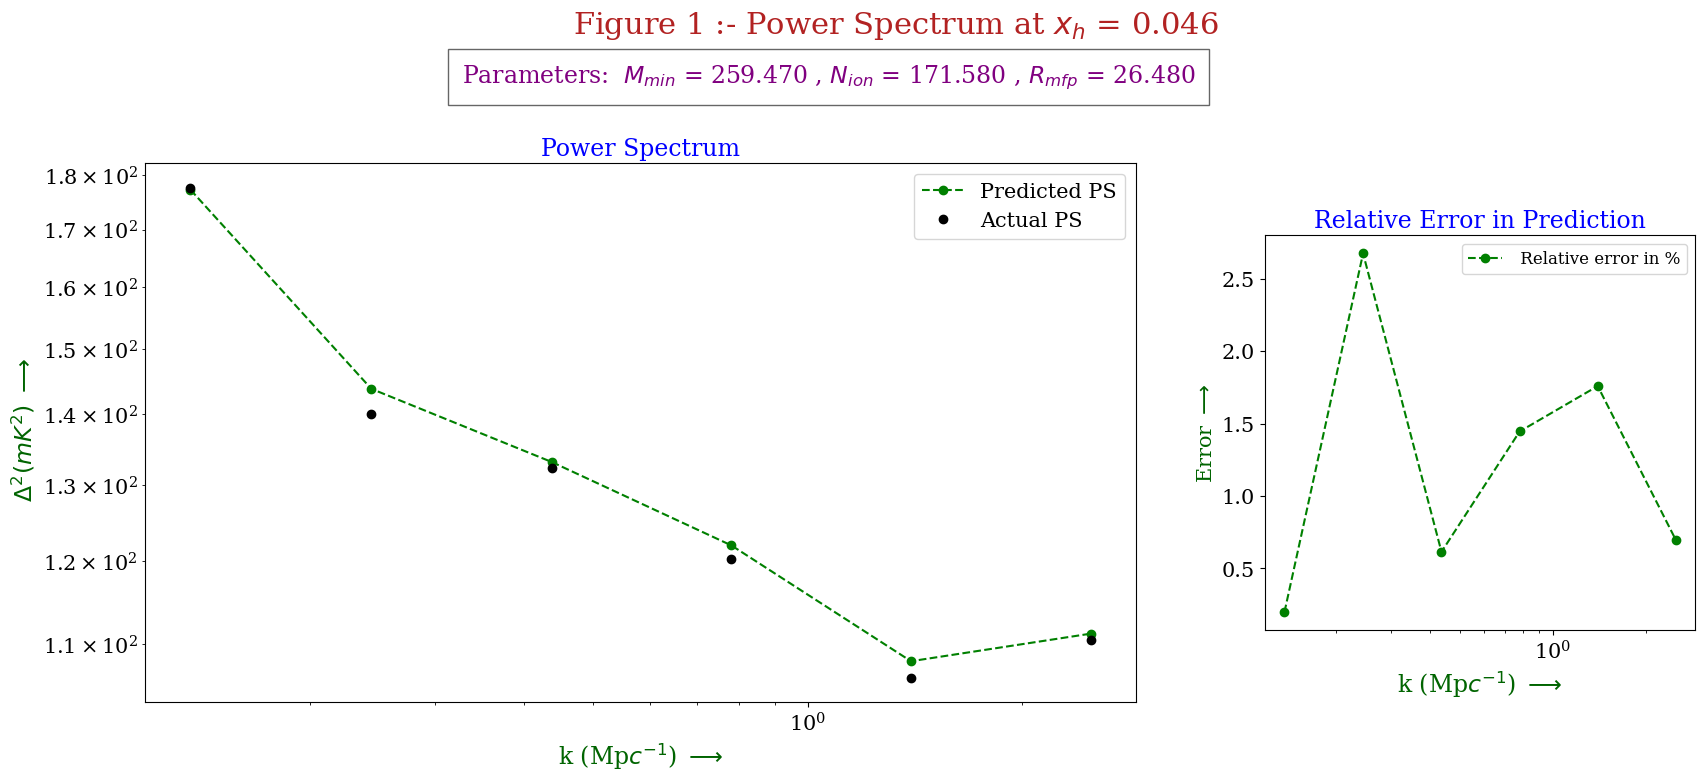

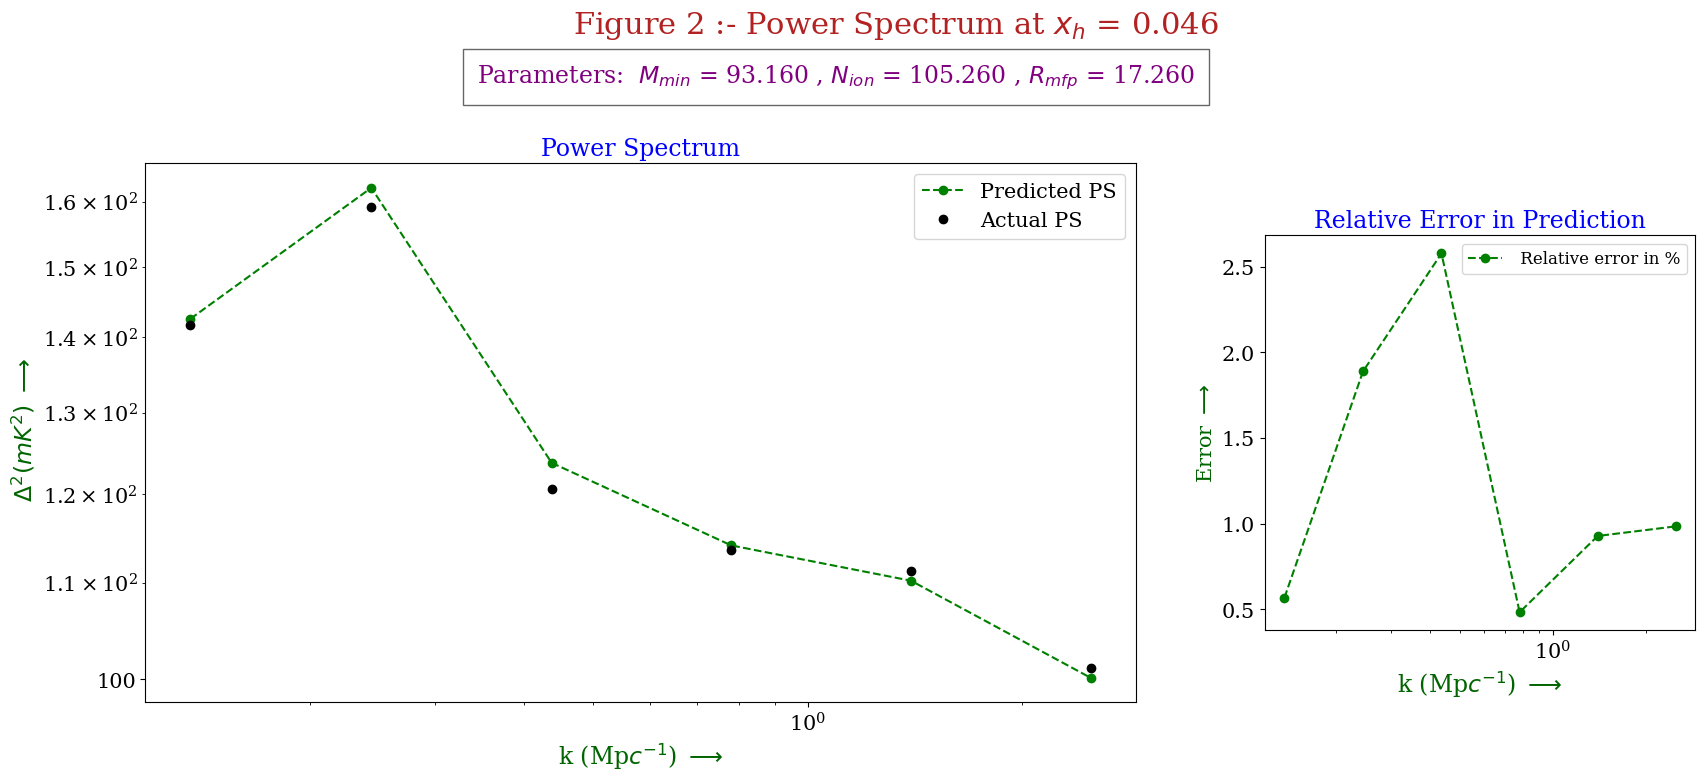

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  0.8


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.8


 ===>  Sorry! I didn't found any Power Spectrum plot at neutral fraction 0.800 in testing data set.

 ===>  Provide a range so that I can give you neighbour neutral fraction values around this 0.800 value.

 ===>  If you want very close value then please provide very short range like 0.01,0.011 etc.

Enter the range (or 'q' to quit):  0.01


 ===>  oh! I found 38 neutral fraction values which are neighbours of previous value

 ===>  List of these values is here:

[0.79  0.79  0.792 0.793 0.793 0.793 0.794 0.795 0.796 0.796 0.796 0.797
 0.797 0.797 0.797 0.797 0.798 0.799 0.799 0.801 0.801 0.802 0.802 0.804
 0.804 0.805 0.805 0.806 0.807 0.809 0.809 0.809 0.809 0.809 0.809 0.809
 0.809 0.809]

 ===>  Please select one of the neutral fraction value from above list at which you want to see the power spectrum.

 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.797


 ===>  I found 5 Power Spectrum plots. How many do you want to see?. Please provide me a number.

Enter a number (or 'q' to quit):  5


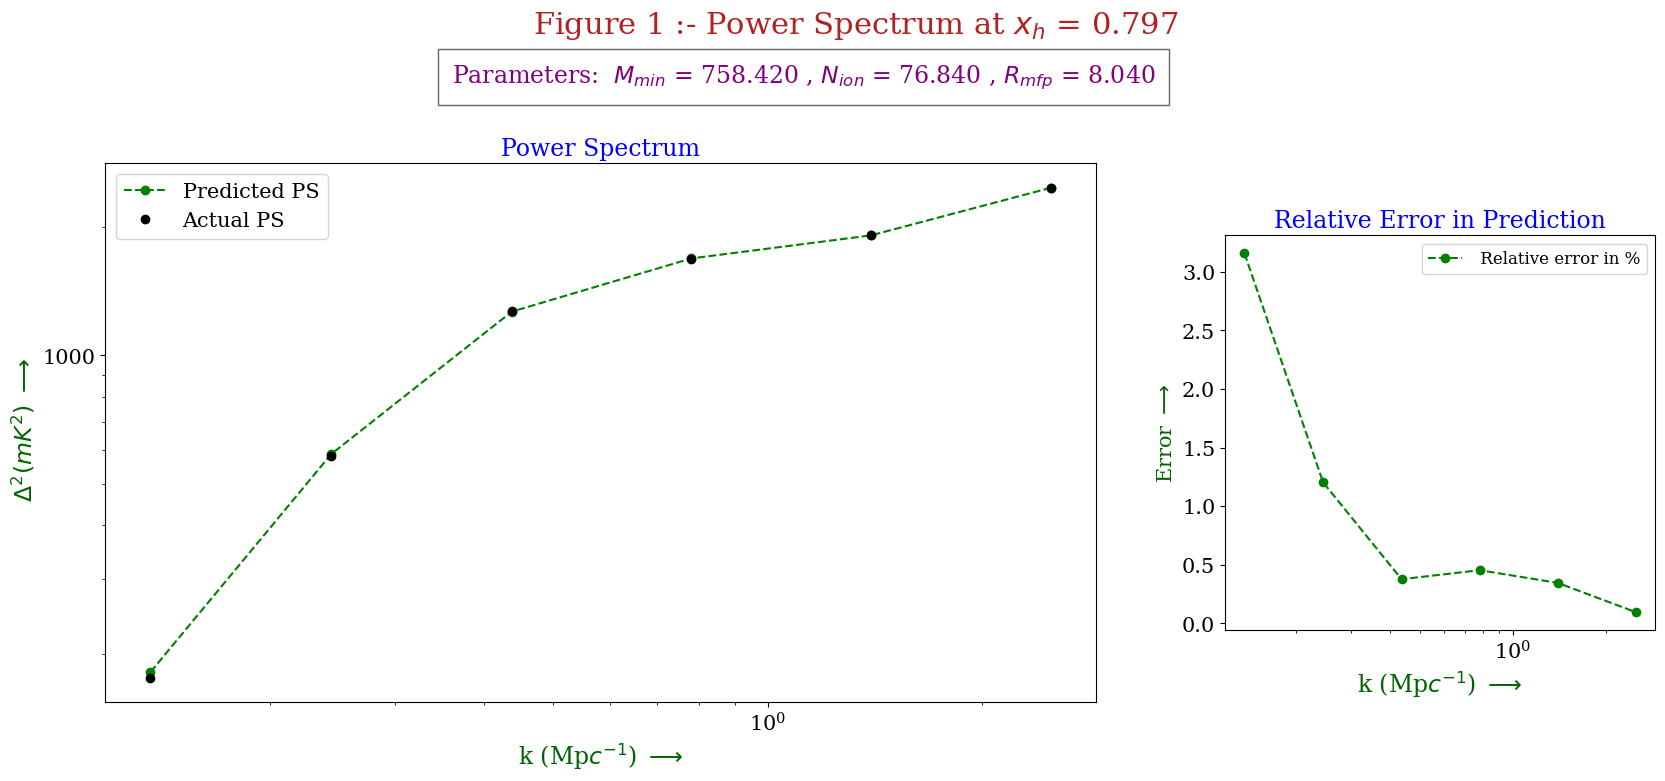

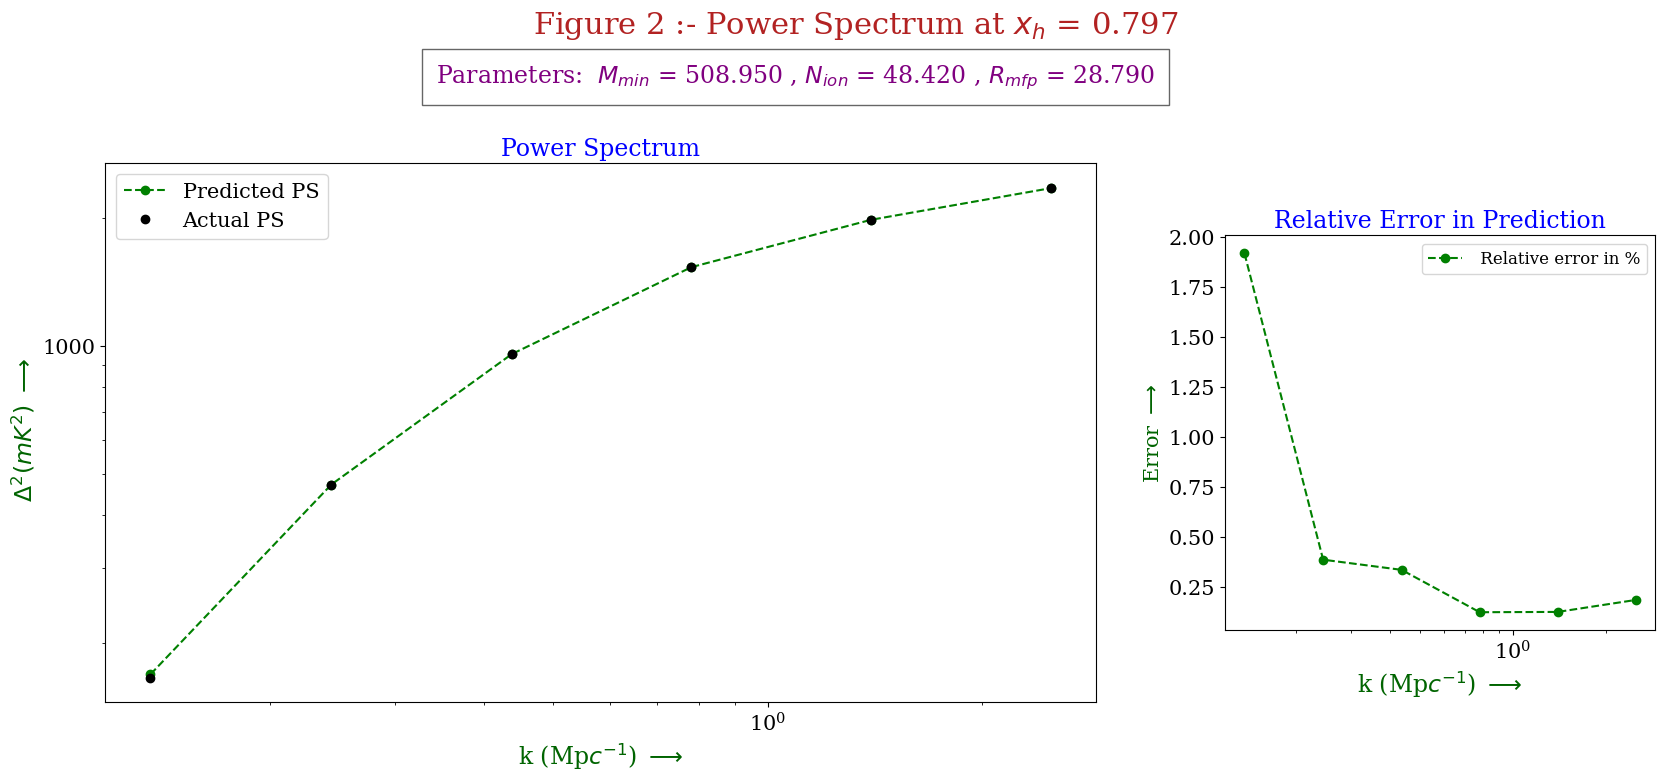

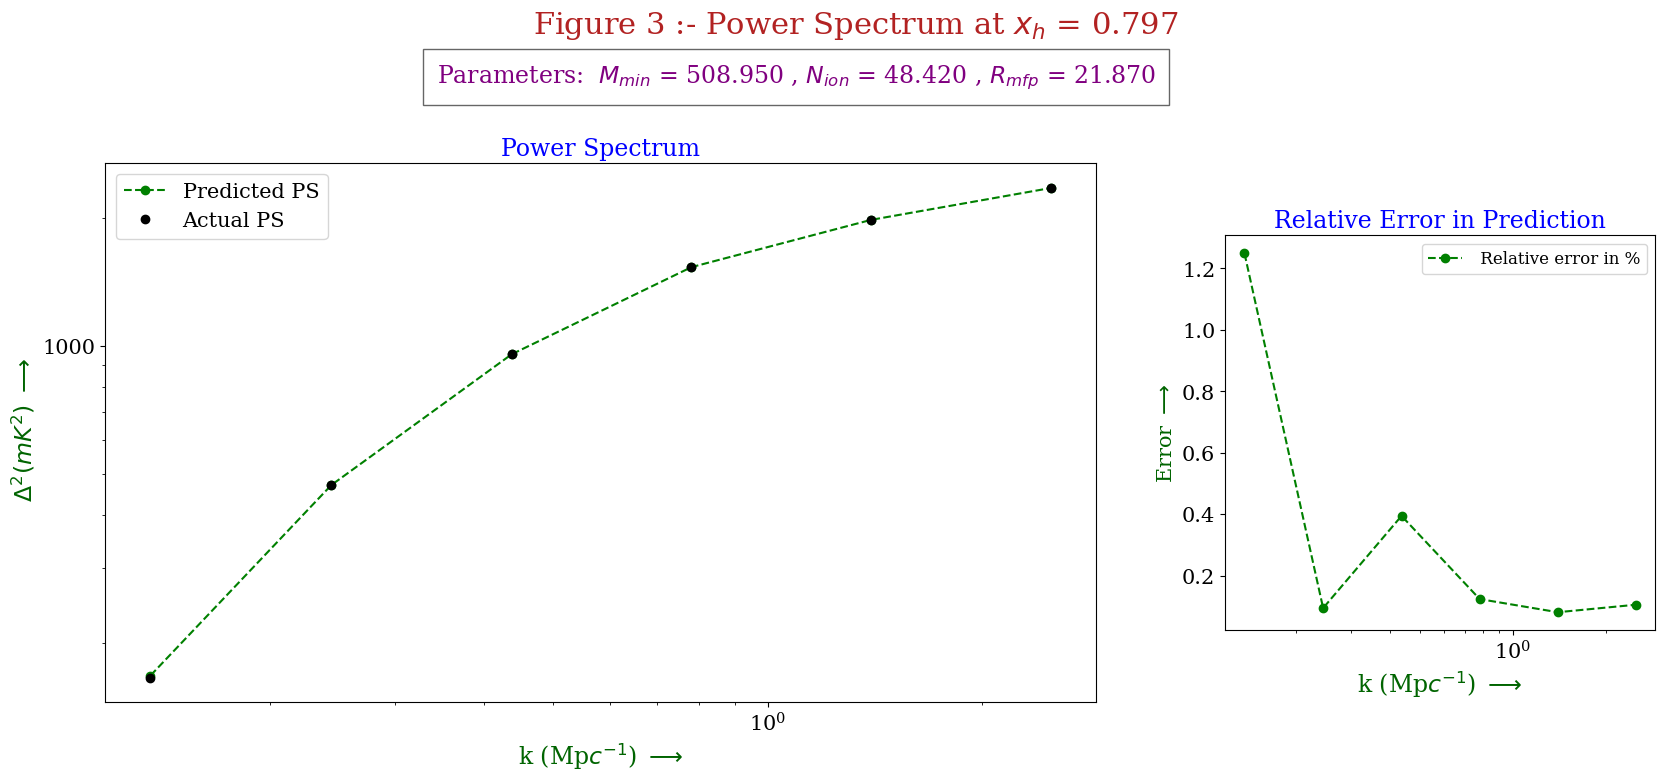

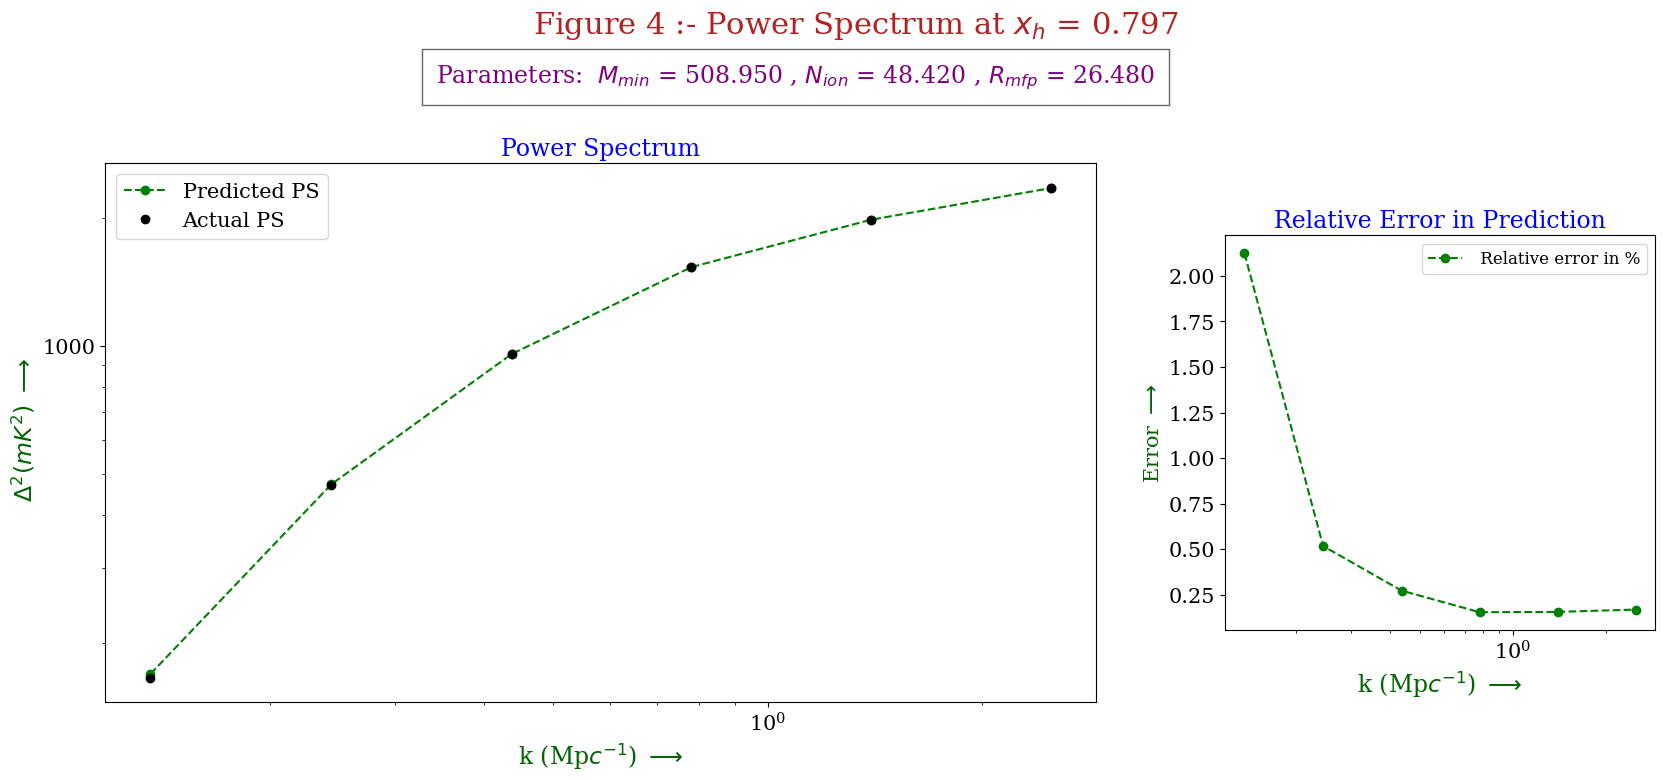

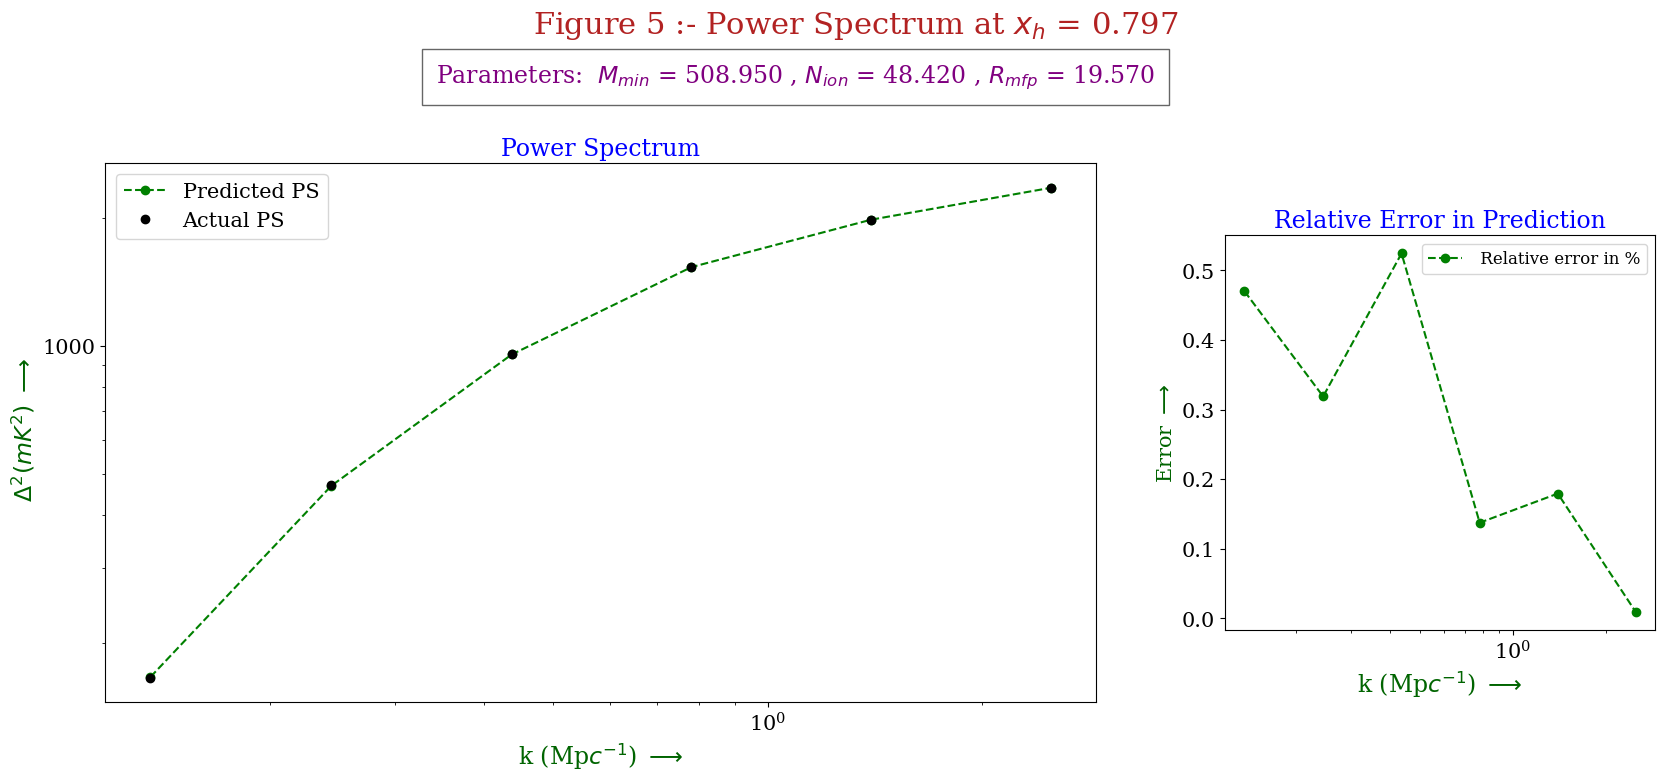

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  c


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.1


 ===>  I found 1 Power Spectrum plots which is here:-

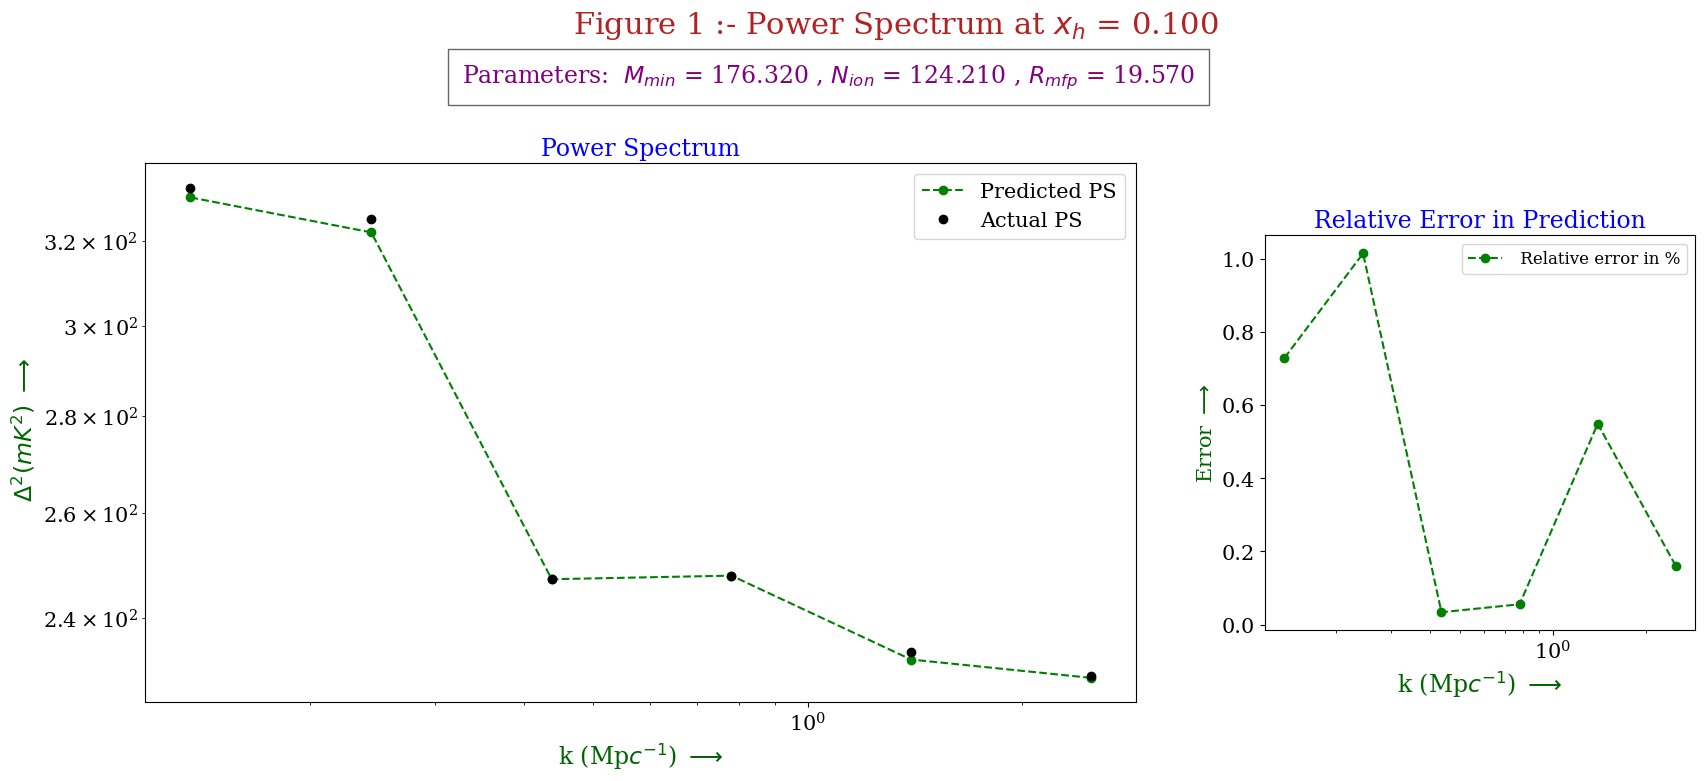

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  0.001


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.001


 ===>  I found 11 Power Spectrum plots. How many do you want to see?. Please provide me a number.

Enter a number (or 'q' to quit):  11


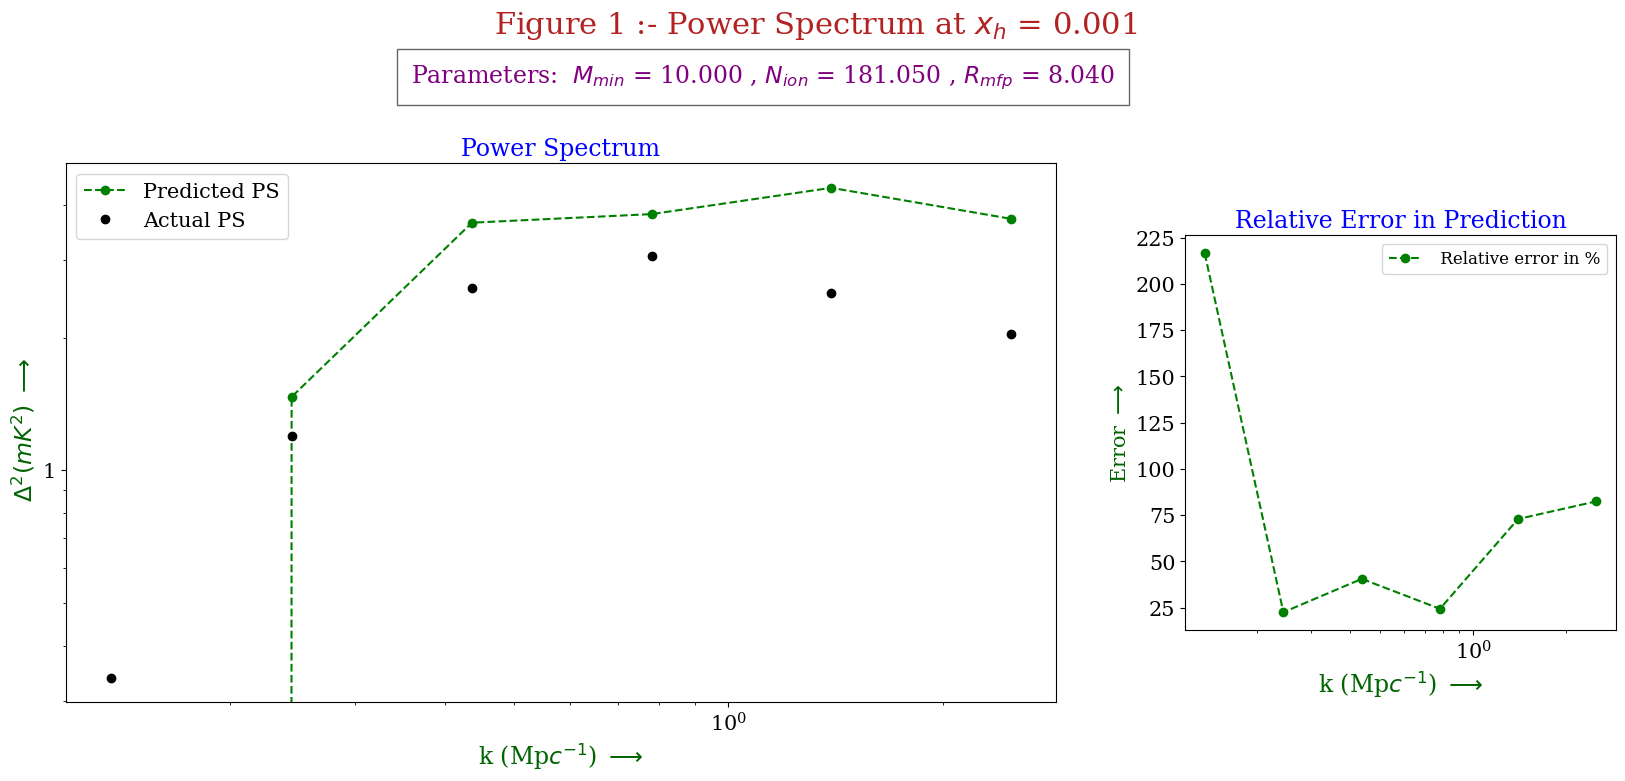

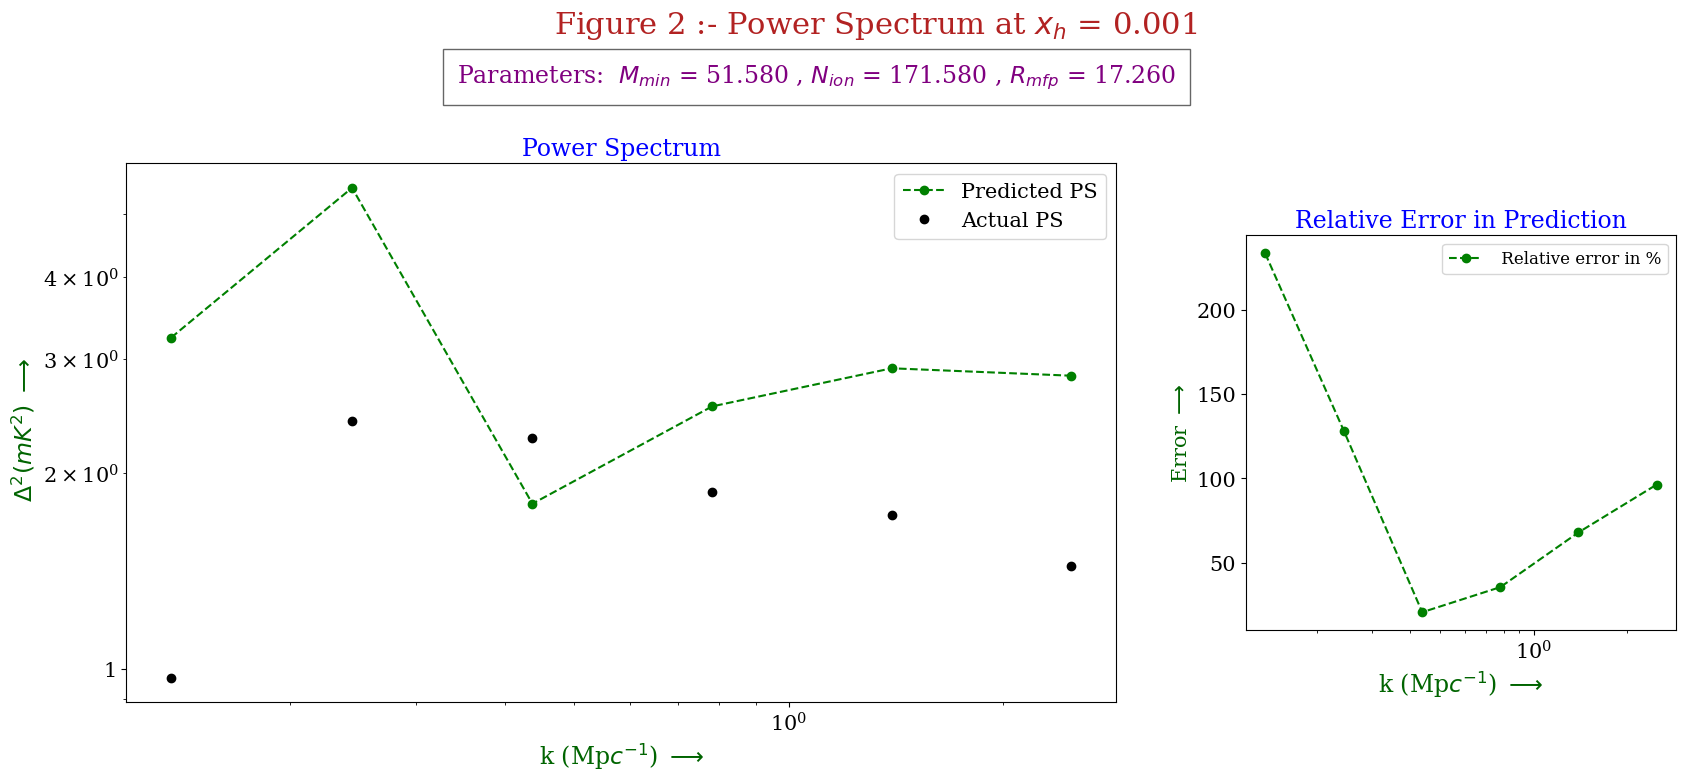

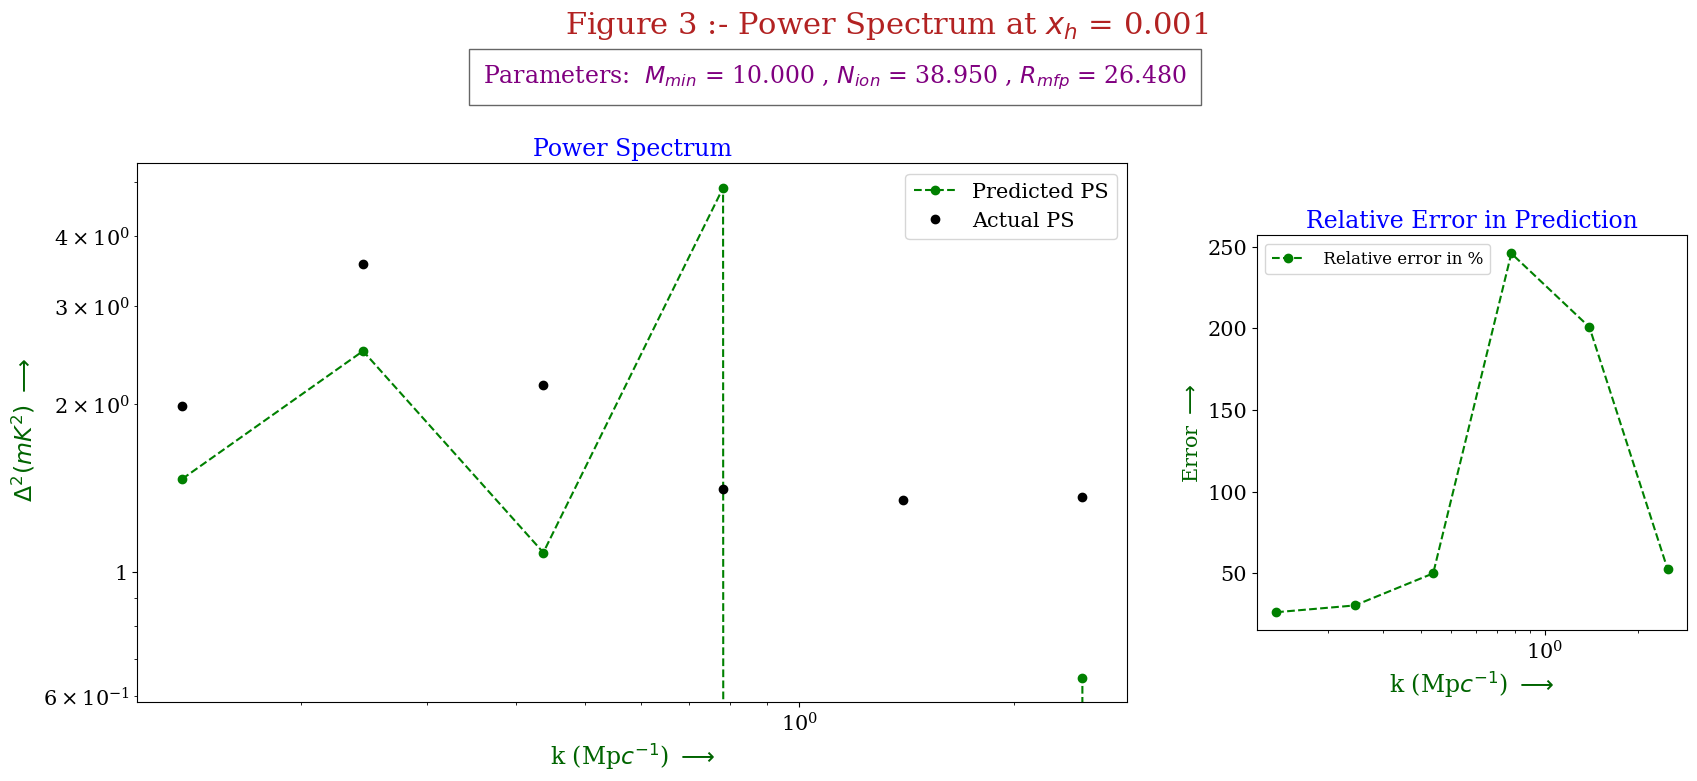

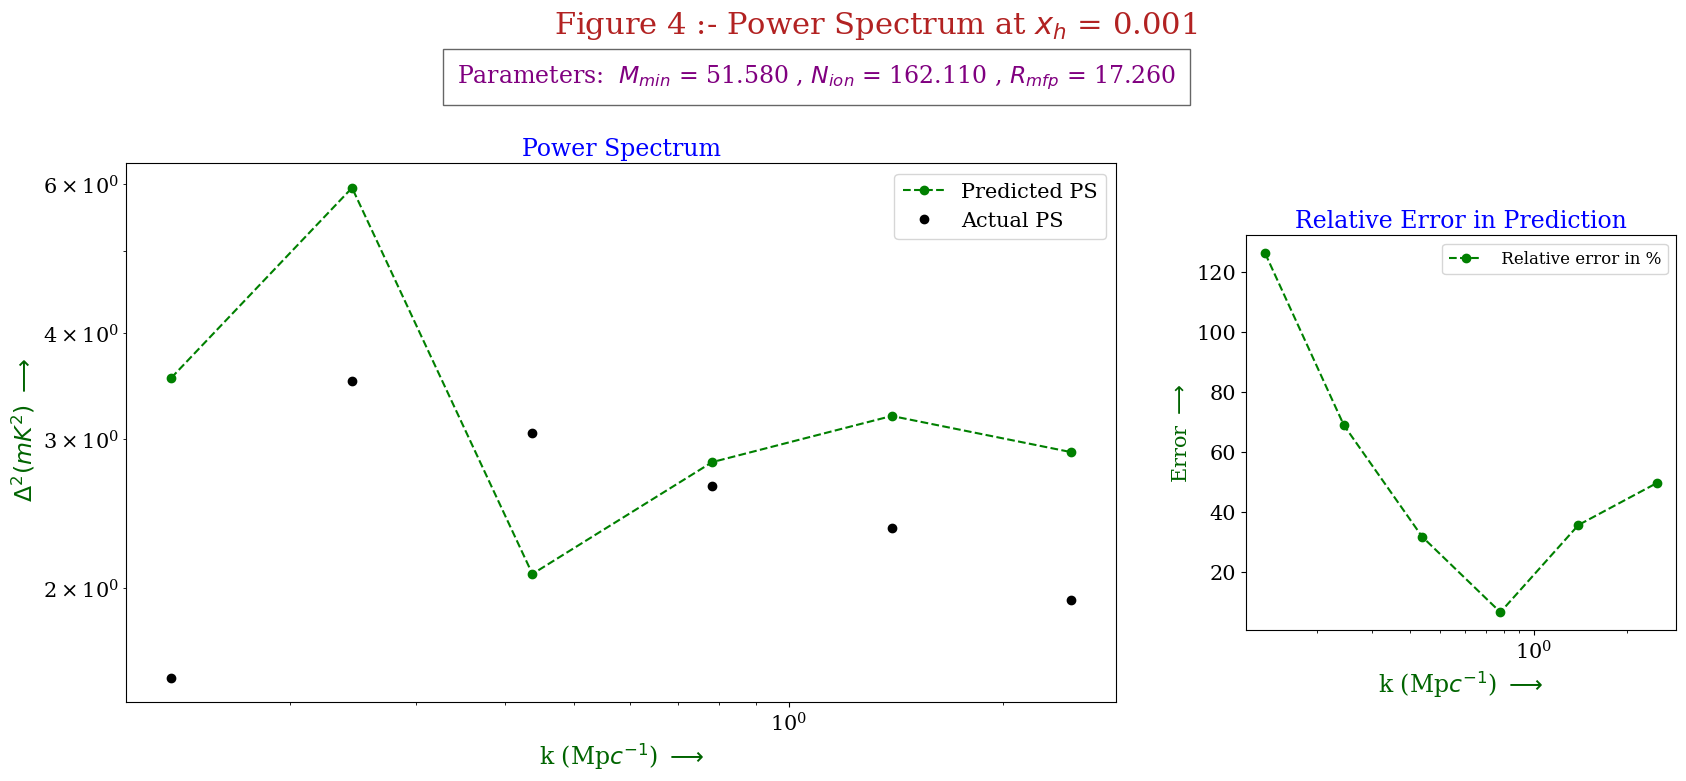

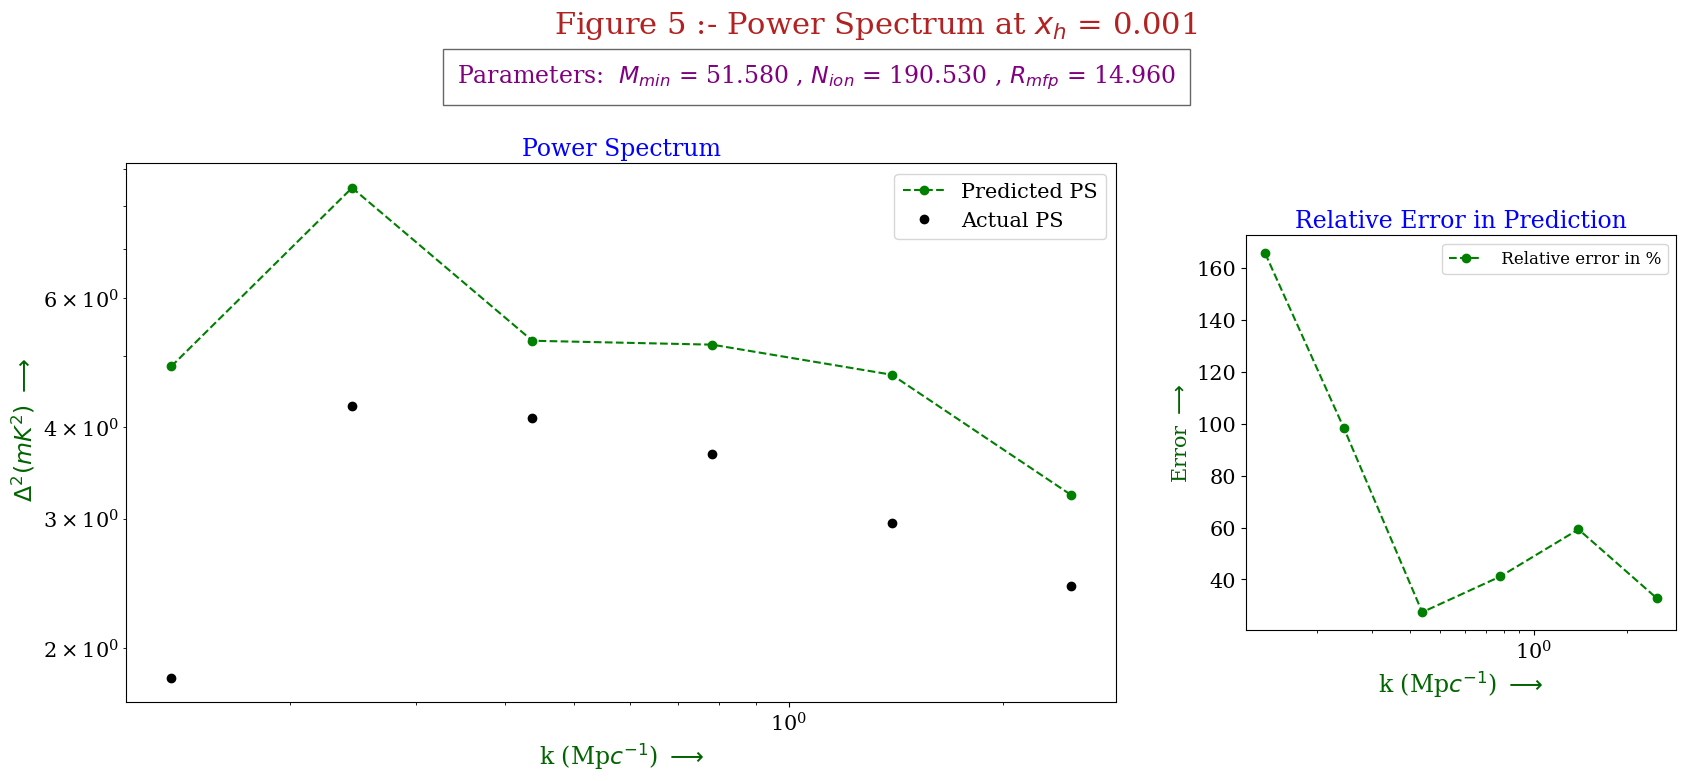

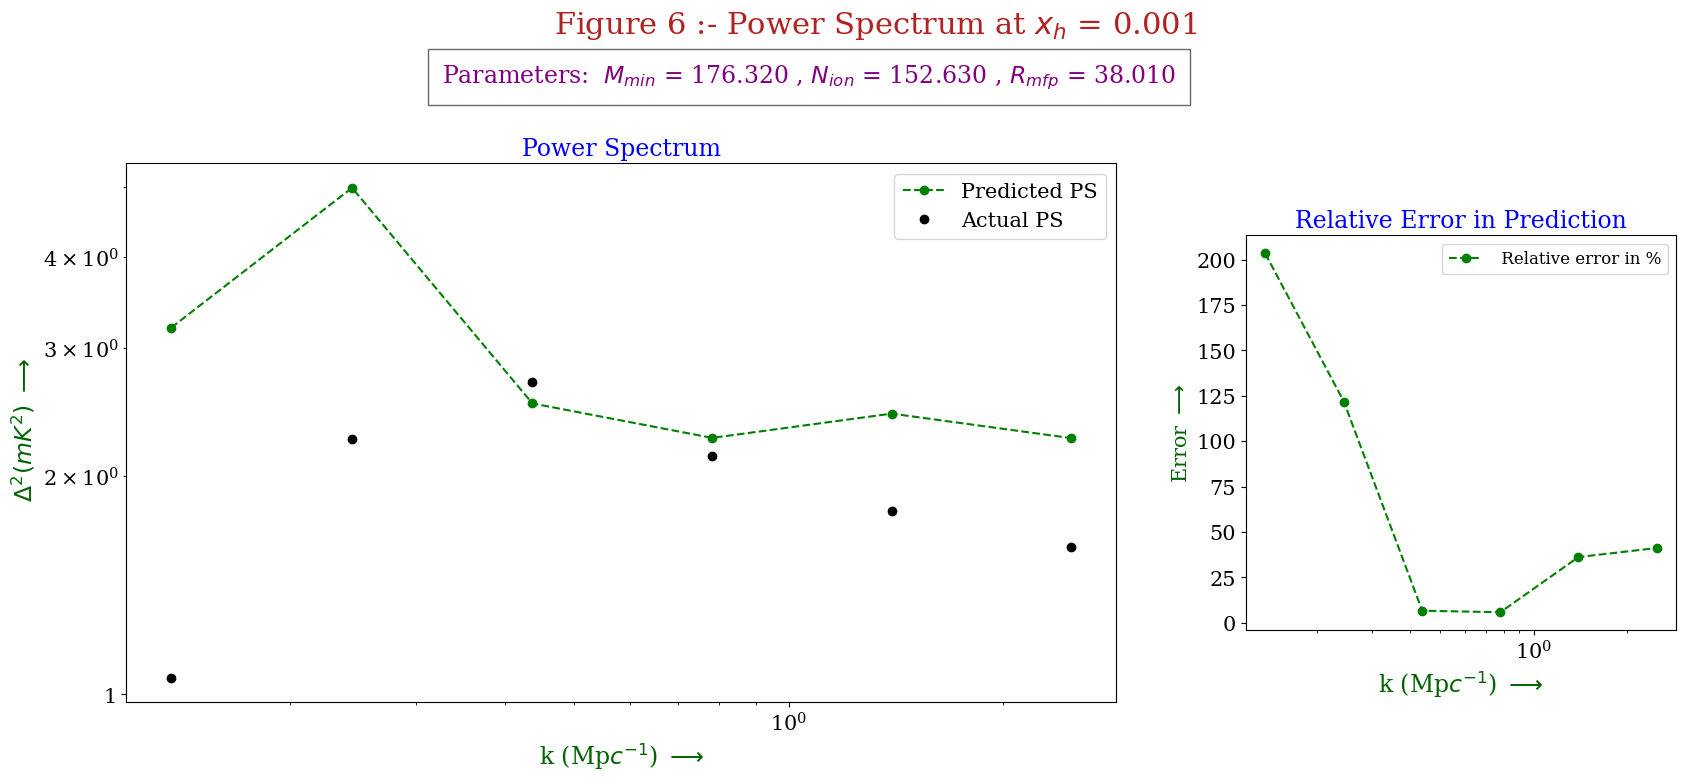

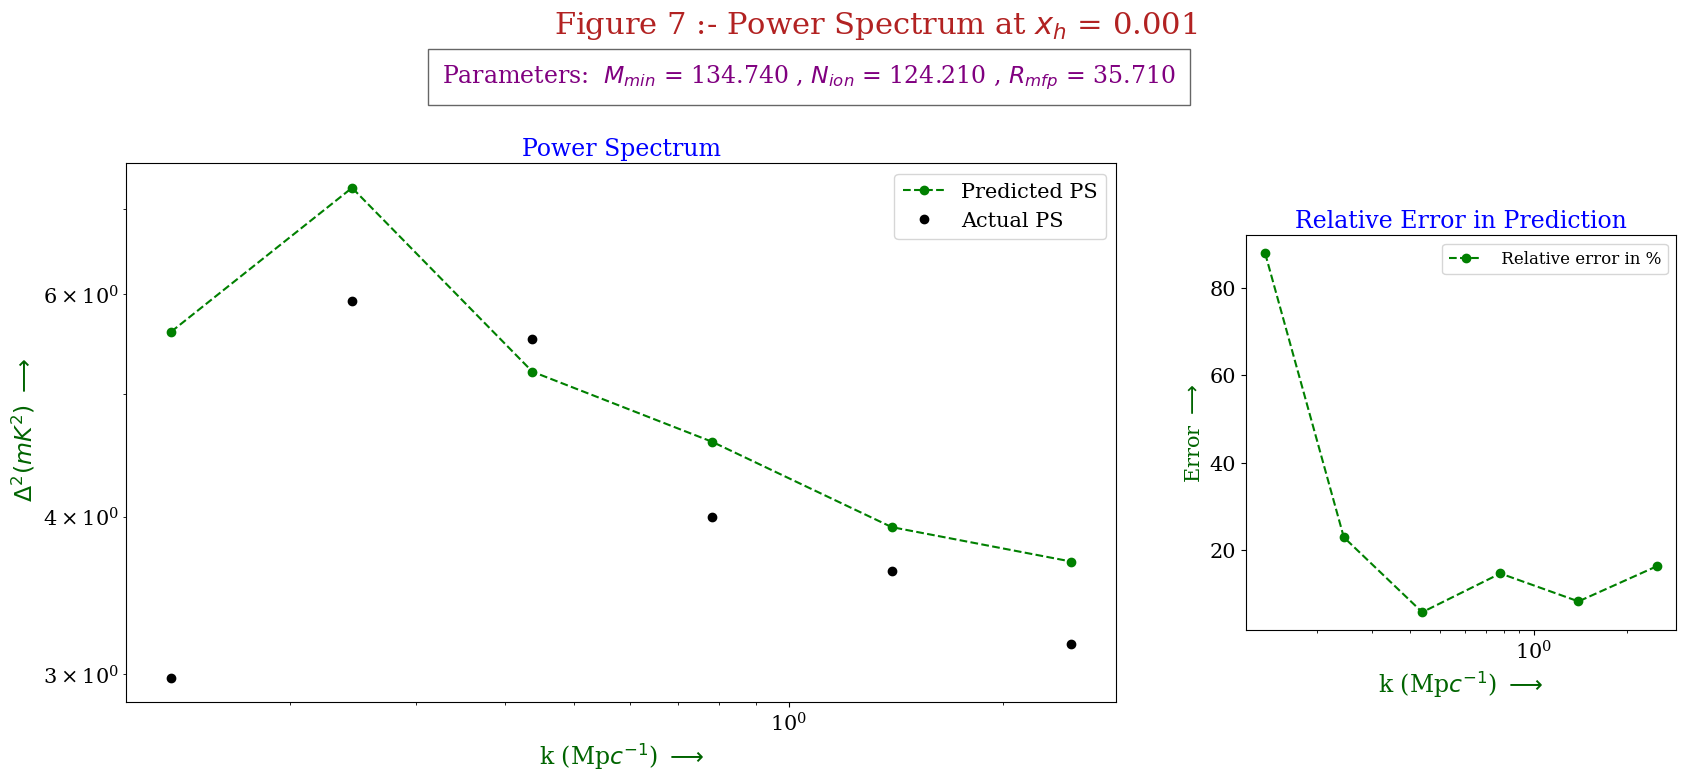

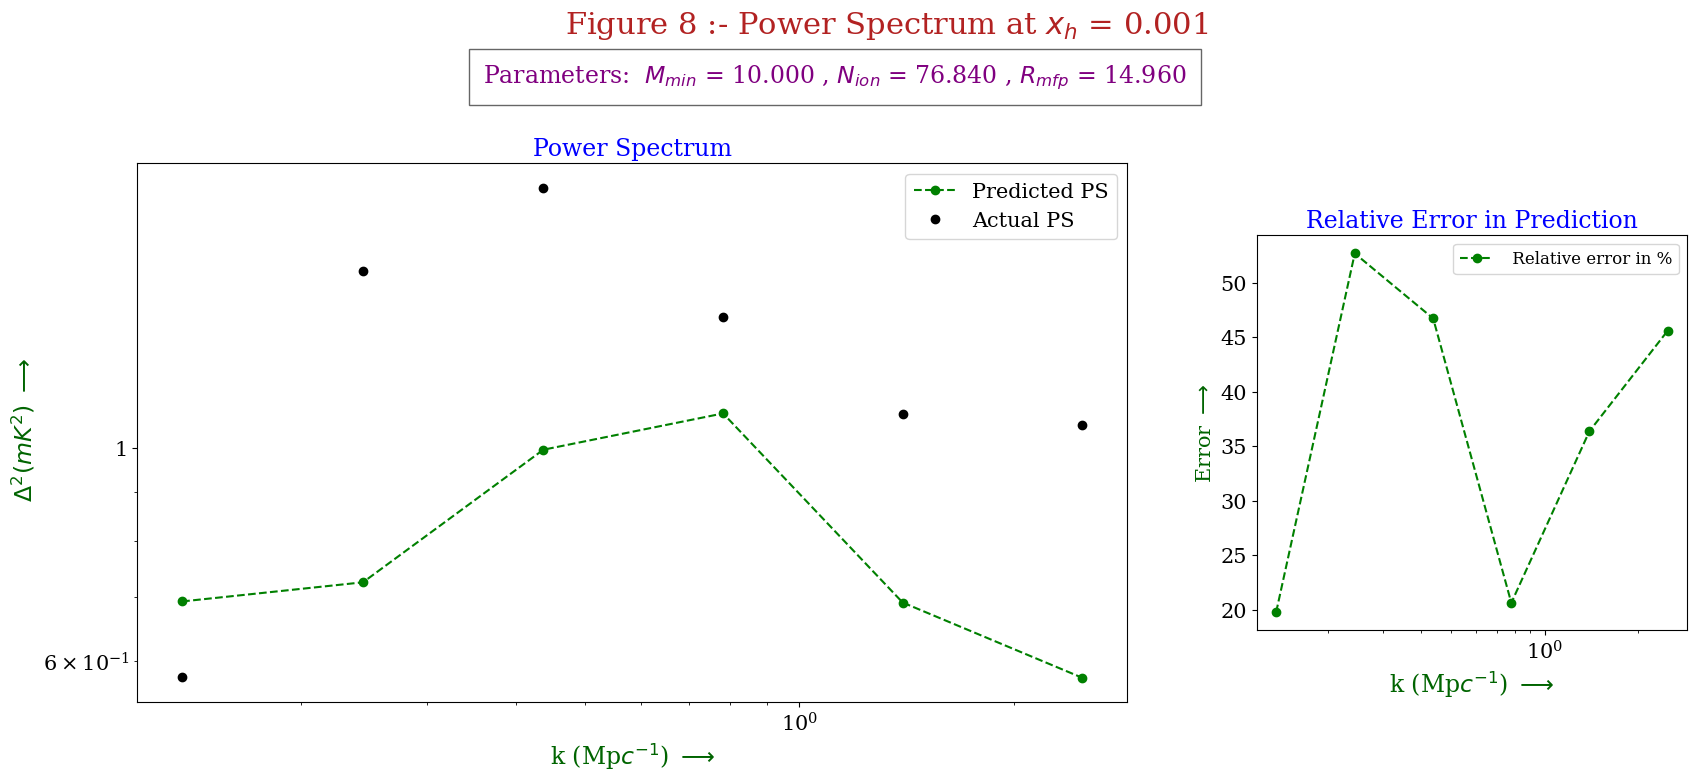

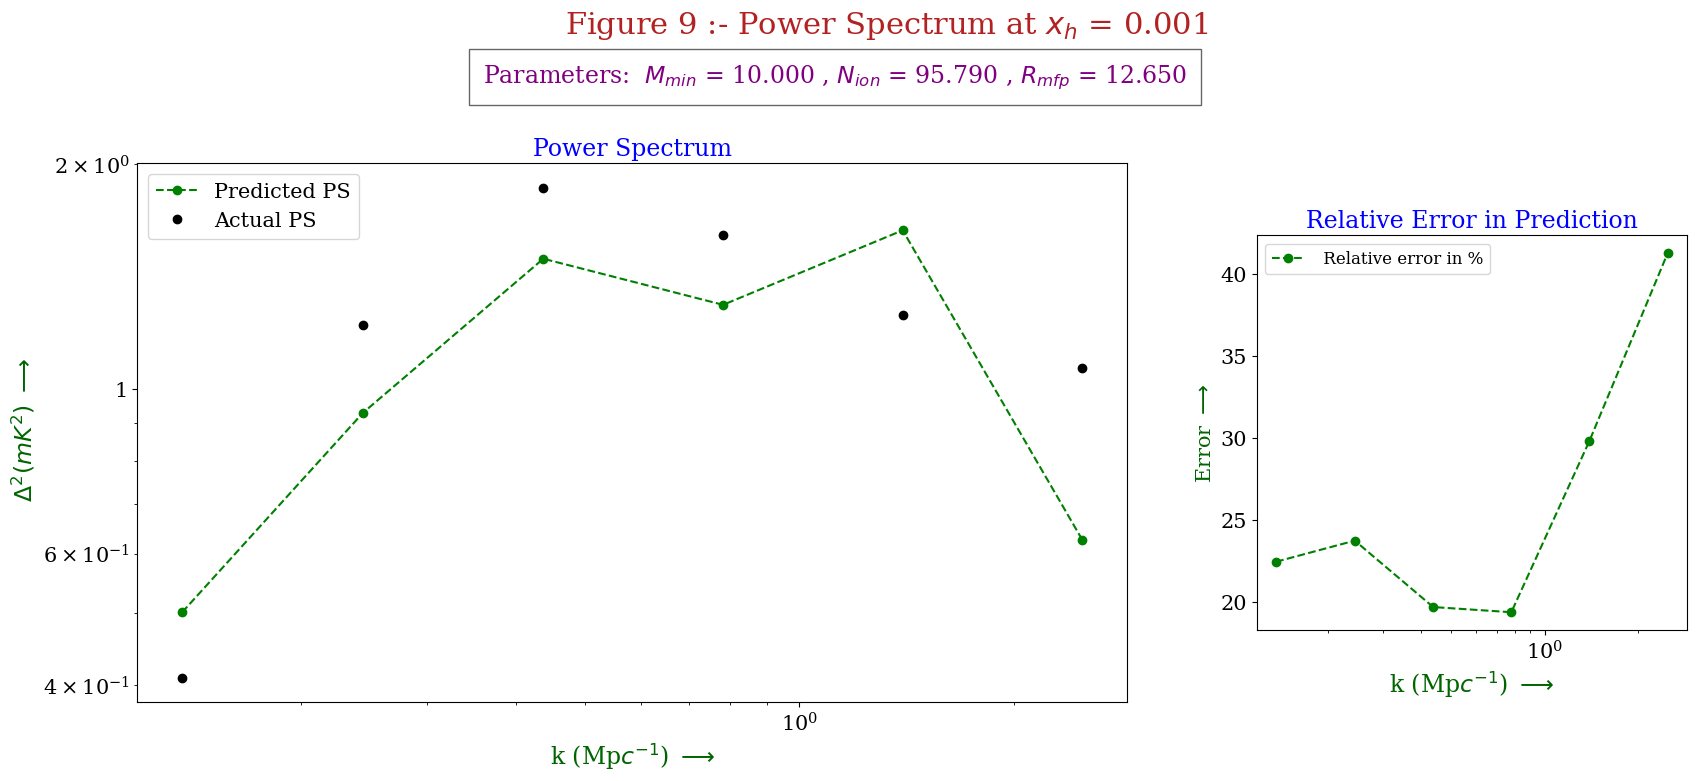

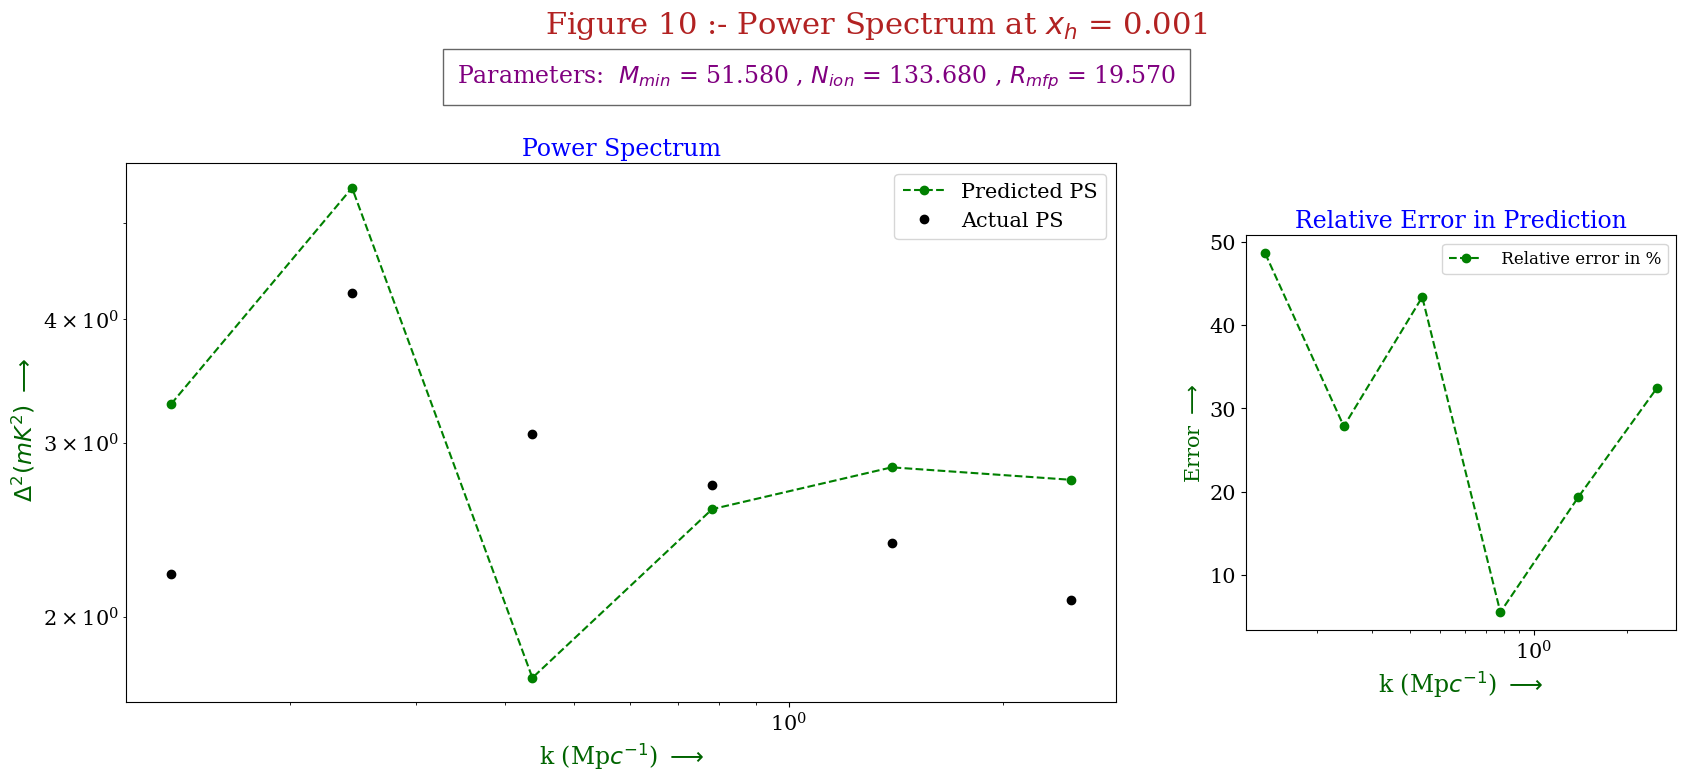

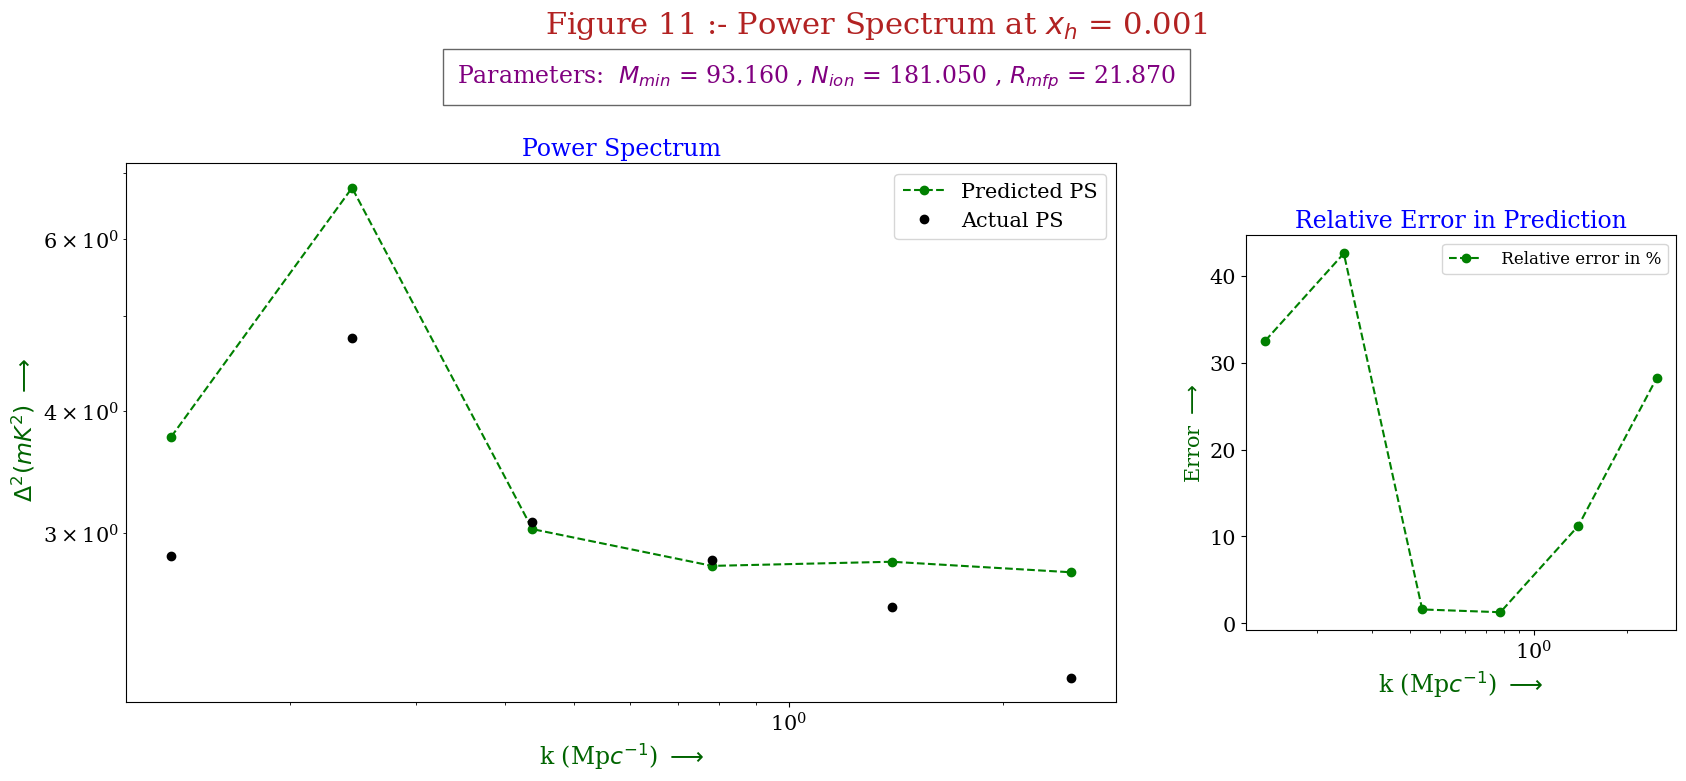

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  c


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.5


 ===>  I found 1 Power Spectrum plots which is here:-

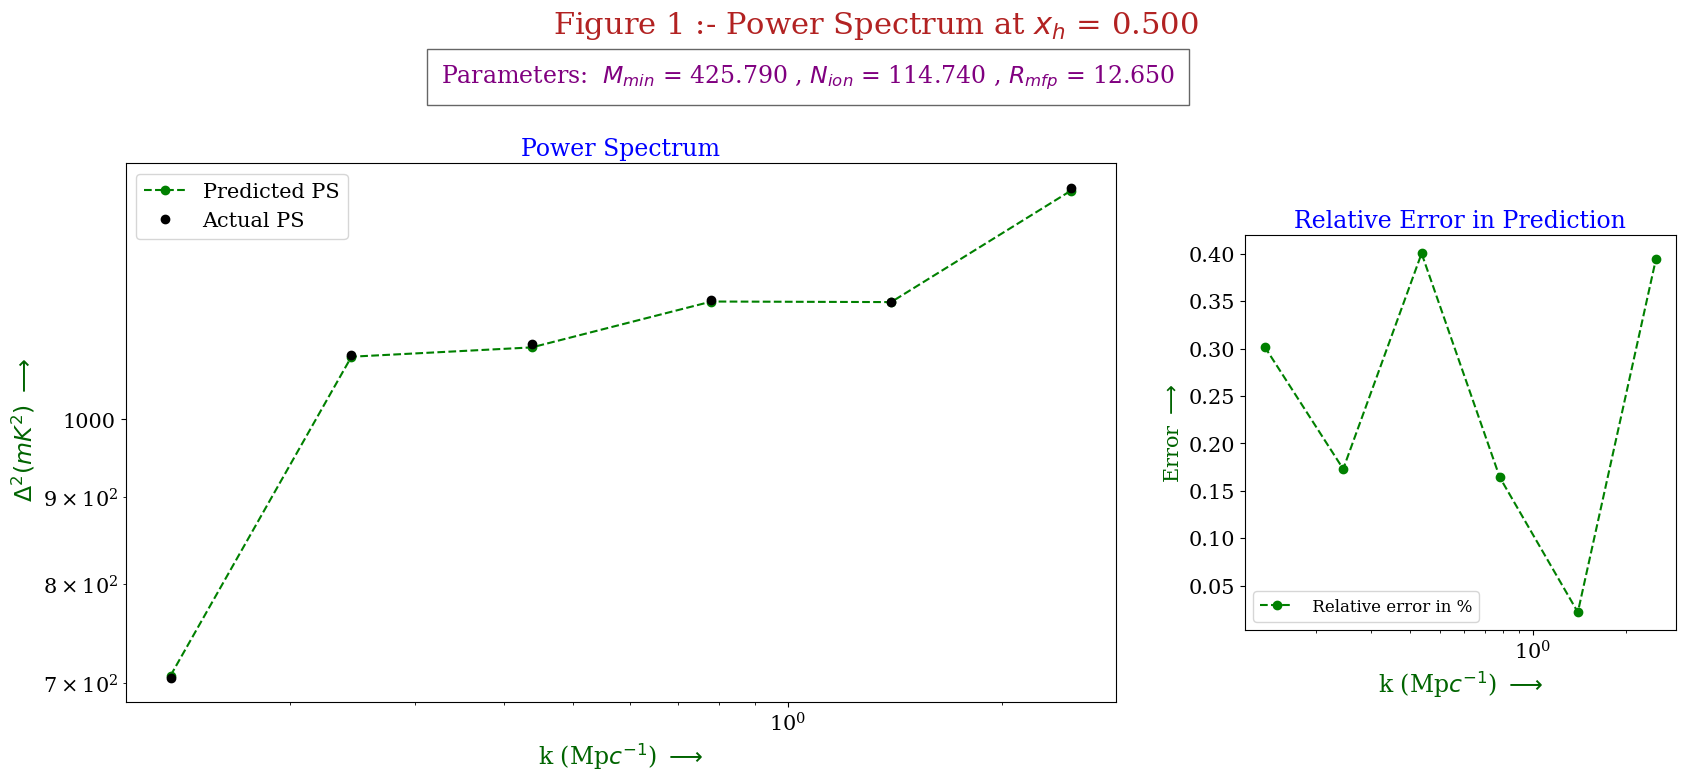

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  c


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.02


 ===>  I found 2 Power Spectrum plots. How many do you want to see?. Please provide me a number.

Enter a number (or 'q' to quit):  2


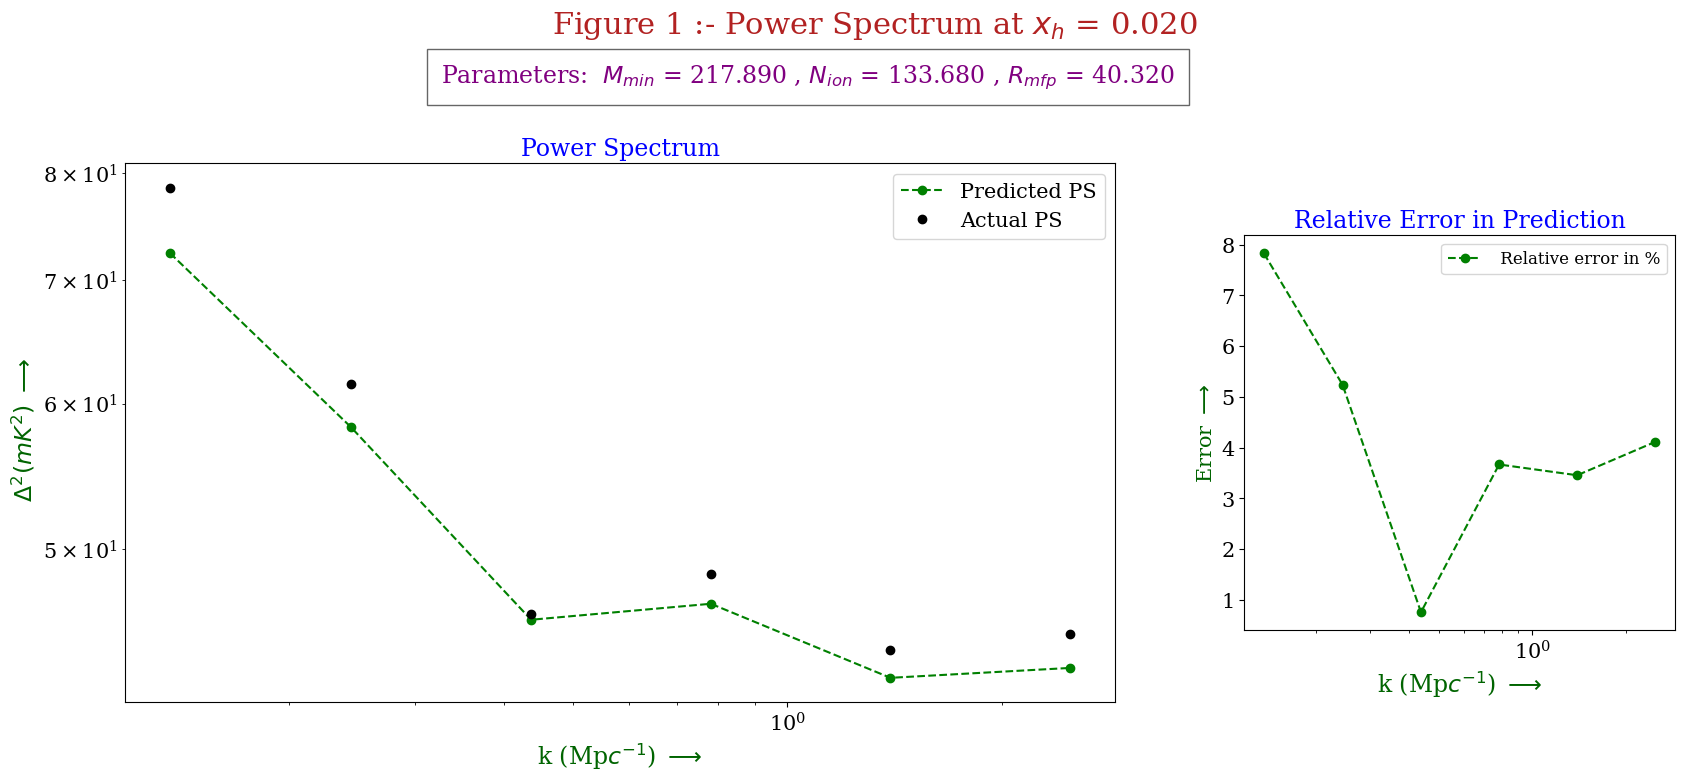

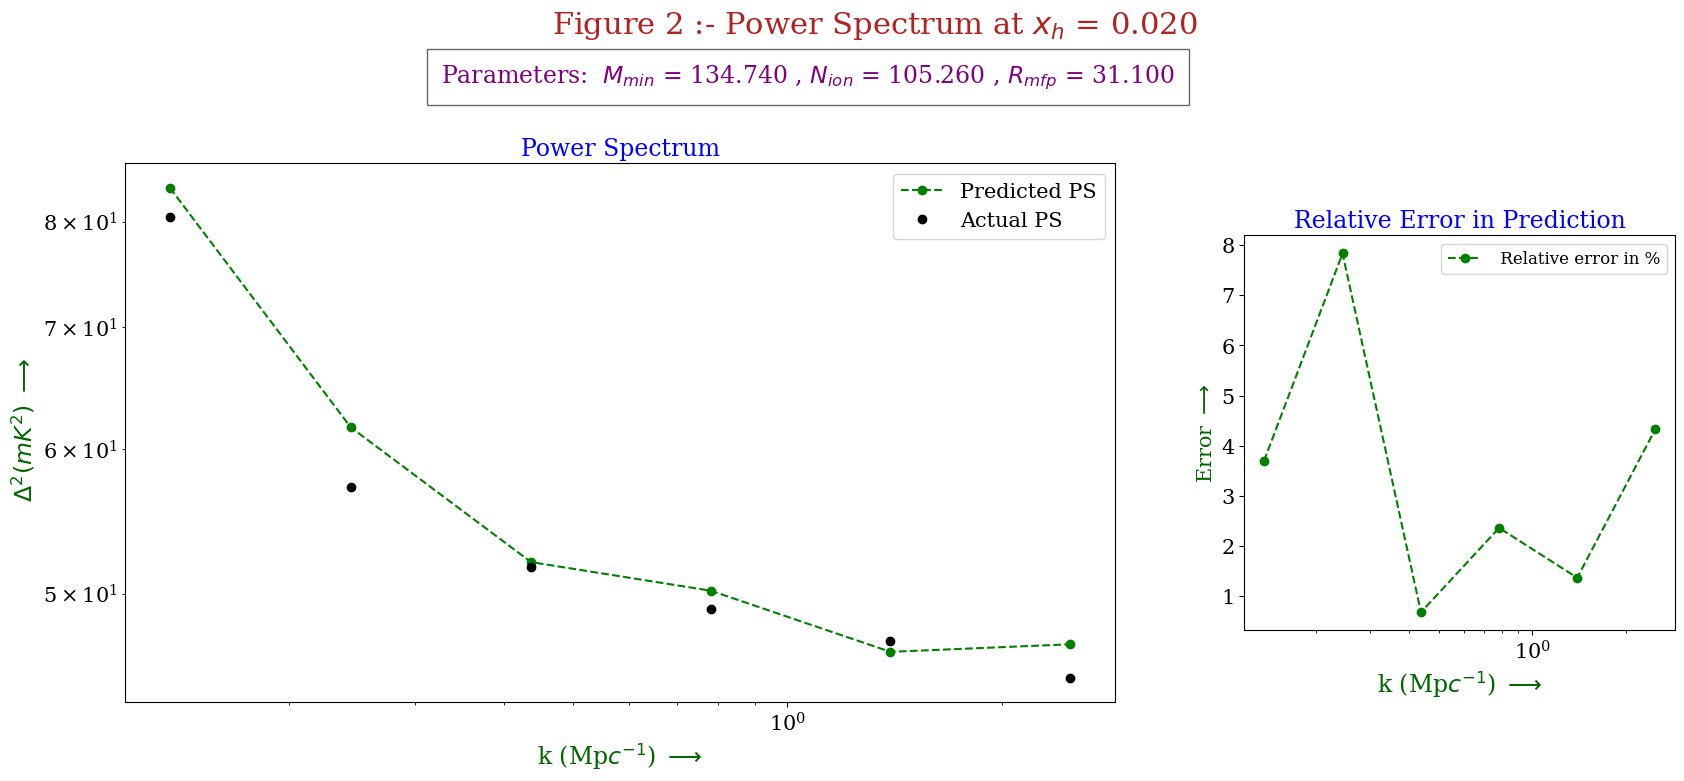

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  c


 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.8


 ===>  Sorry! I didn't found any Power Spectrum plot at neutral fraction 0.800 in testing data set.

 ===>  Provide a range so that I can give you neighbour neutral fraction values around this 0.800 value.

 ===>  If you want very close value then please provide very short range like 0.01,0.011 etc.

Enter the range (or 'q' to quit):  0.001


 ===>  oh! I found 4 neutral fraction values which are neighbours of previous value

 ===>  List of these values is here:

[0.799 0.799 0.801 0.801]

 ===>  Please select one of the neutral fraction value from above list at which you want to see the power spectrum.

 Instructions:-

 Please provide me the value of neutral fraction at which you want to see the Power Spectrum.

 Note: The value of neutral fraction should be between 0 to 1.

Enter a number (or 'q' to quit):  0.801


 ===>  I found 2 Power Spectrum plots. How many do you want to see?. Please provide me a number.

Enter a number (or 'q' to quit):  2


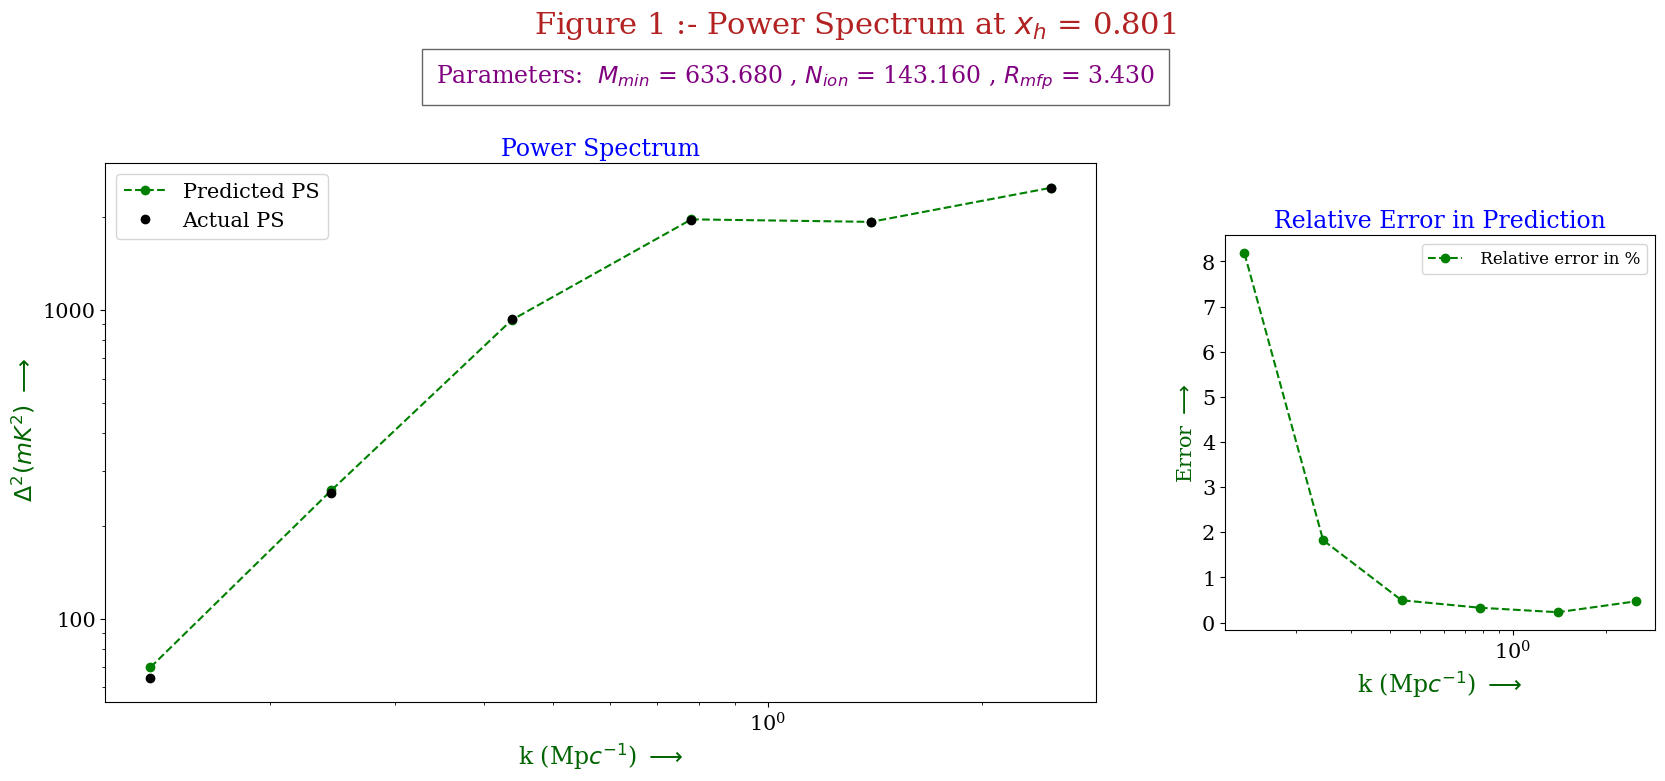

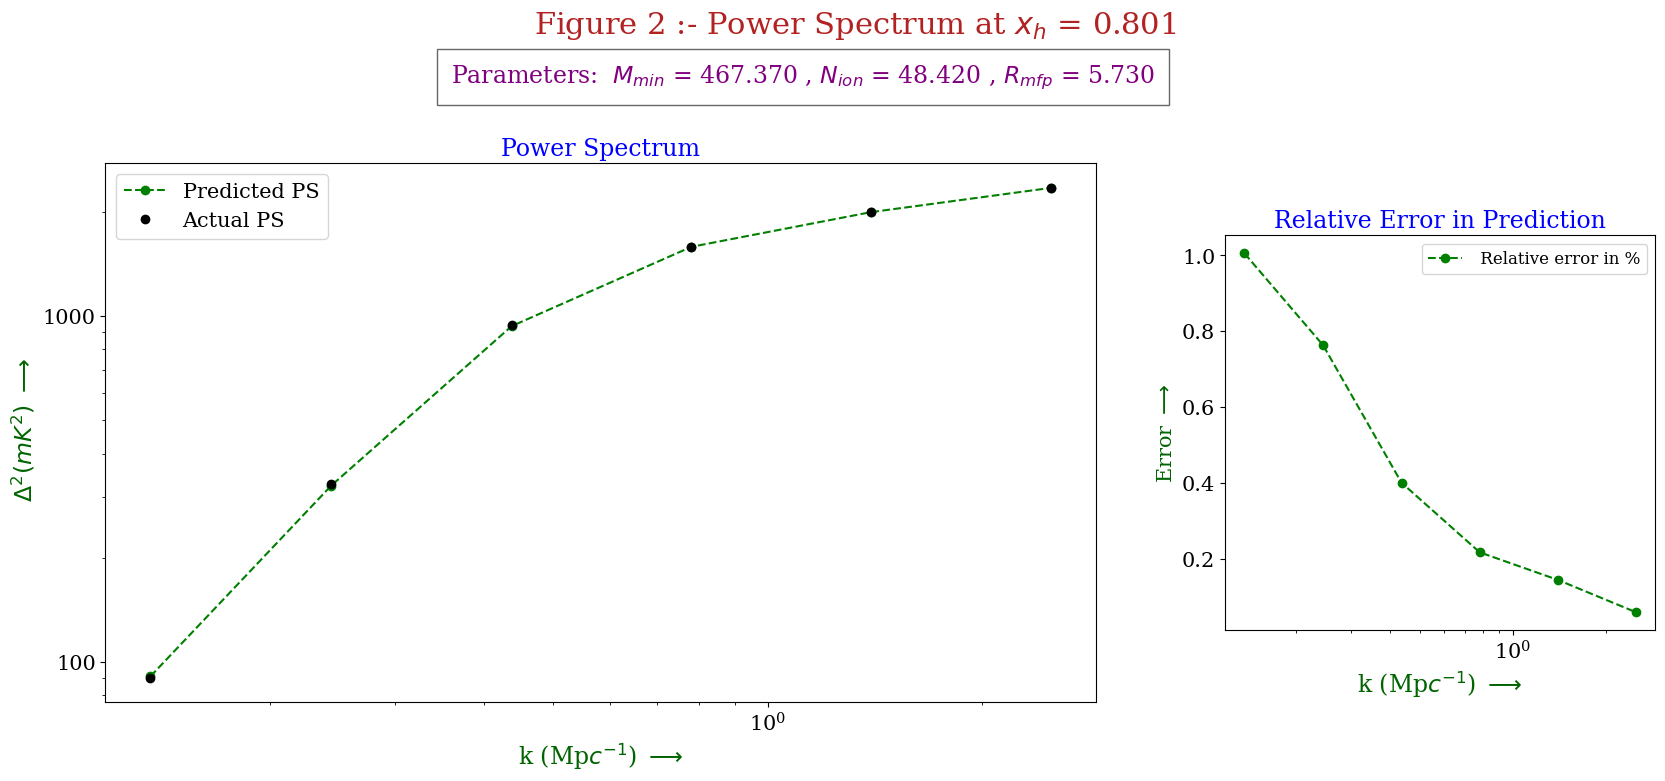

 ===> Do you want to continue it or quit it? If you want to continue then enter 'c' or if you want to quit it then 
enter 'q'

Enter your choice:  q


In [46]:
Interactive_result()

## $\textit{Hyper Parameter Tunning}$

In [ ]:
import optuna
import tensorflow as tf
from tensorflow import keras

def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    # Build and compile the neural network with the suggested learning rate
    model = keras.Sequential([
        keras.layers.Dense(512,kernel_initializer = 'uniform', activation = 'elu',input_dim = 3),
        keras.layers.Dense(1024, activation='elu'),
        keras.layers.Dense(128, activation='elu'),
        keras.layers.Dense(64, activation='elu'),
        
        keras.layers.Dense(6)
    ])
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train and evaluate the model
    history = model.fit(x_train, y_train, epochs=200,batch_size = 15, validation_split=0.1, verbose=0)
    return history.history['val_loss'][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Best learning rate:', study.best_params['learning_rate'])
print('Best loss:', study.best_value)



In [ ]:
def get_piechart(xh,a,san):    
    data = np.array(xh).reshape(len(xh),)
    data1 = pd.DataFrame(data)
    ssa = data1.groupby(pd.cut(data, a,right = False,precision = 2,include_lowest = True)).count()

    bs = ssa[0]
    label = bs.index
    bs = np.array(bs)

    labels =label
    sizes = bs
    max_index = np.argmax(sizes)
    min_index = np.argmin(sizes)


    explode = [0.3 if i in [max_index, min_index] else 0 for i in range(len(labels))]


    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.2f%%', shadow=False, startangle=140)
    plt.axis('equal')
    plt.text(-1,1.5,"Pie chart for {} values in {} different ranges".format(san,a),fontsize = 17,color = "blue")
    plt.show()
get_piechart(xh,5,"Neutral Fraction")
# get_piechart(M,5,"M_min")
get_piechart(N,5,"N_ion")
# get_piechart(R,10,"R_mfp")
    